In [ ]:
!pip install vnstock==0.2.9.0
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
from datetime import datetime
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
import IPython
from vnstock import *
from collections import Counter

# **1. GIẢ THUYẾT VỀ CHIẾN THUẬT**

##**1.1. Chiến thuật nổ volume kết hợp cùng momentum**


**Định nghĩa:**

Chiến thuật "Nổ Volume" là một phương pháp giao dịch tập trung vào việc phân tích khối lượng giao dịch đột biến và sức mạnh xu hướng (Momentum), nhằm xác định các cơ hội giao dịch tiềm năng với xác suất thành công cao.

**Nguyên tắc giao dịch:**

Mua khi giá tăng mạnh kèm khối lượng lớn:
Giá tăng đột biến kèm theo khối lượng giao dịch vượt trung bình báo hiệu xu hướng tăng mạnh.
Bán khi giá giảm mạnh kèm khối lượng lớn:
Giá giảm với khối lượng lớn cho thấy rủi ro giảm giá cao.
Gia tăng vị thế khi giá quay lại đường MA100 hoặc MA200:
Các đường trung bình động dài hạn (MA100, MA200) được xem như vùng hỗ trợ động, nơi giá có xu hướng bật tăng trở lại. Đây là cơ hội tốt để gia tăng vị thế trong xu hướng tăng dài hạn.

**Lựa chọn cổ phiếu dựa vào sức mạnh Momentum:**

Momentum đo lường sức mạnh xu hướng giá của cổ phiếu, được tính toán và sắp xếp để chọn ra các cổ phiếu tốt nhất.

Quy trình chọn lọc cổ phiếu Momentum:
Tính Momentum:
Sử dụng độ dốc của đường hồi quy tuyến tính trên logarit giá trong một khoảng thời gian nhất định (ví dụ: 20, 50 ngày). Cổ phiếu có độ dốc càng cao cho thấy xu hướng càng mạnh.
Sắp xếp và chọn lọc:
Chọn nhóm cổ phiếu top 20% có Momentum mạnh nhất để đưa vào danh mục.
Đánh giá lại hàng tháng:
Momentum được cập nhật định kỳ để đảm bảo danh mục luôn gồm các cổ phiếu dẫn đầu xu hướng. ( Mỗi tháng cập nhật lại sức mạnh momentum 1 lần)

**Phân tích hiệu quả:**

Chiến lược được backtest trên dữ liệu lịch sử để kiểm tra khả năng sinh lời, với các tiêu chí đánh giá:
Tỷ suất lợi nhuận (Return): Tổng lợi nhuận danh mục qua các tháng.

Độ sụt giảm tối đa (Max Drawdown): Giới hạn rủi ro giảm giá.

Tỷ lệ thắng (Win Rate): Phần trăm các giao dịch có lợi nhuận.

Tối ưu hóa danh mục: Phân bổ vốn vào các cổ phiếu Momentum mạnh nhất.

Sharpe Ratio: Đánh giá hiệu quả lợi nhuận trên mỗi đơn vị rủi ro, giúp so sánh chiến lược với các phương pháp đầu tư khác.

**Tối ưu hóa**

Trong đó, tiến hành tối ưu hóa base position size( tỷ trọng cơ bản của cổ phiếu) và stock ratio ( tỷ trọng chọn số % cổ phiếu trong quá trình chọn lọc cổ phiếu momentum)

# **2. THU THẬP DỮ LIỆU**

In [ ]:
# Danh sách các mã cổ phiếu cần phân tích
list = [
    "AAA", "ACB", "AGG", "ANV", "ASM",
    "BCG", "BCM", "BID", "BMP", "BVH",
    "BWE", "CII", "CMG", "CRE", "CTD",
    "CTG", "CTR", "DBC", "DCM", "DGC",
    "DGW", "DHC", "DIG", "DPM", "DXG",
    "DXS", "EIB", "FPT", "FRT", "FTS",
    "GAS", "GEG", "GEX", "GMD", "GVR",
    "HCM", "HDB", "HDC", "HDG", "HHV",
    "HPG", "HSG", "HT1", "IMP", "KBC",
    "KDC", "KDH", "KOS", "LPB", "MBB",
    "MSB", "MSN", "MWG", "NKG", "NLG",
    "NT2", "NVL", "OCB", "PAN", "PC1",
    "PDR", "PHR", "PLX", "PNJ", "POW",
    "PPC", "PTB", "PVD", "PVT", "REE",
    "SAB", "SAM", "SBT", "SCR", "SCS",
    "SHB", "SJS", "SSB", "SSI", "STB",
    "SZC", "TCB", "TCH", "TMS", "TPB",
    "VCB", "VCG", "VCI", "VHC", "VHM",
    "VIB", "VIC", "VIX", "VJC", "VND",
    "VNM", "VPB", "VPI", "VRE", "VSH"
]

In [ ]:
# Danh sách cổ phiếu
list

# Khởi tạo dictionary để lưu dữ liệu
stock_data = {}

# Tải dữ liệu
for i in list:
    stock=stock_historical_data( i,'2014-01-01','2024-12-31')
    stock.columns=['datetime','open','high',
                   'low','close','volume','ticker']
    stock['datetime']=pd.to_datetime(stock['datetime'])
    stock.set_index('datetime',inplace=True)
    stock_data[i] = stock  # Lưu dữ liệu vào dictionary

# Hiển thị dữ liệu cho từng cổ phiếu
for ticker, data in stock_data.items():
    print(f"Dữ liệu của cổ phiếu {ticker}:")
    # Hiển thị 5 dòng đầu tiên
    print(data.head())
    print("\n")


Dữ liệu của cổ phiếu AAA:
            open  high   low  close  volume ticker
datetime                                          
2014-01-02  5237  5237  5178   5207  126000    AAA
2014-01-03  5178  5207  5148   5178   78500    AAA
2014-01-06  5207  5355  5207   5326  242510    AAA
2014-01-07  5444  5444  5326   5385  292040    AAA
2014-01-08  5326  5385  5296   5355  267000    AAA


Dữ liệu của cổ phiếu ACB:
            open  high   low  close  volume ticker
datetime                                          
2014-01-02  2730  2730  2700   2730  146982    ACB
2014-01-03  2730  2750  2700   2750   98656    ACB
2014-01-06  2700  2750  2700   2730  190009    ACB
2014-01-07  2750  2800  2730   2760  152905    ACB
2014-01-08  2760  2760  2730   2750   58852    ACB


Dữ liệu của cổ phiếu AGG:
             open   high    low  close  volume ticker
datetime                                             
2020-01-09  15300  15300  15300  15300  403500    AGG
2020-01-10  15560  15970  15510  15510  38

<ipython-input-7-0fca0ff0e9b8>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_5_tickers = sorted(stock_data, key=lambda ticker: stock_data[ticker]['close'][-1], reverse=True)[:5]


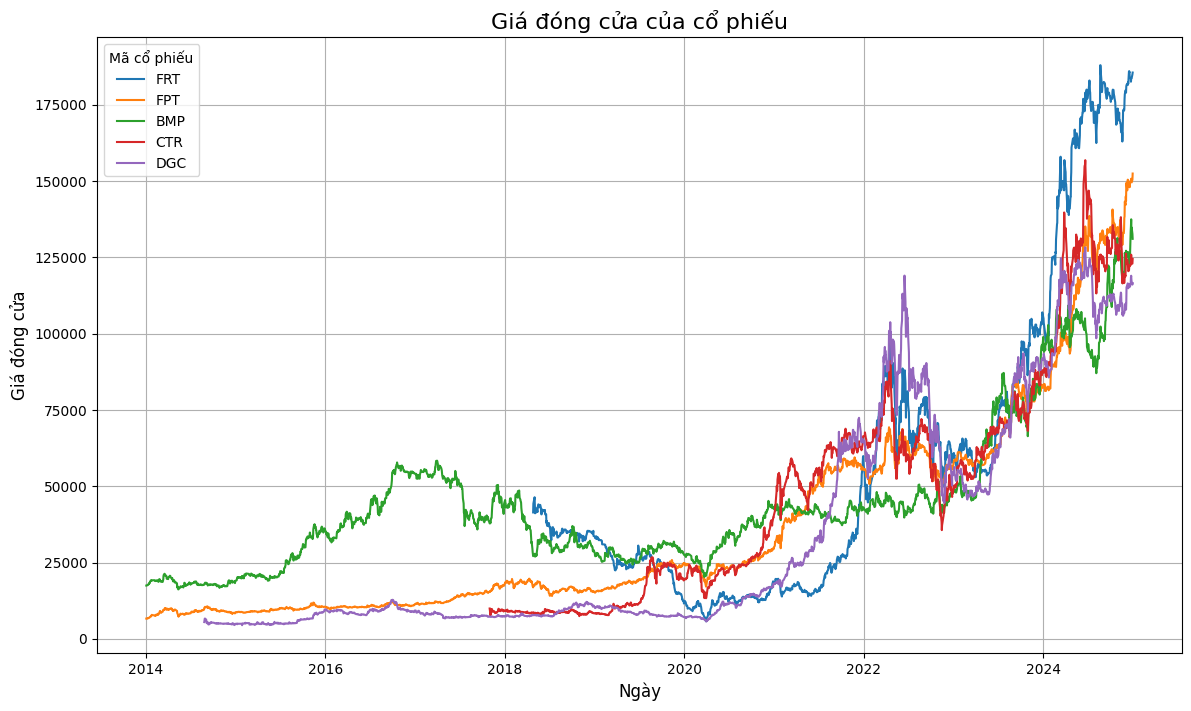

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 8))  # Tạo kích thước biểu đồ

# Lấy 5 mã cổ phiếu có giá đóng cửa cao nhất
top_5_tickers = sorted(stock_data, key=lambda ticker: stock_data[ticker]['close'][-1], reverse=True)[:5]

for ticker in top_5_tickers:
    data = stock_data[ticker]
    plt.plot(data['close'], label=ticker)  # Vẽ giá đóng cửa

# Thêm nhãn và tiêu đề
plt.title("Giá đóng cửa của cổ phiếu", fontsize=16)
plt.xlabel("Ngày", fontsize=12)
plt.ylabel("Giá đóng cửa", fontsize=12)
plt.legend(title="Mã cổ phiếu")  # Hiển thị chú thích
plt.grid(True)
plt.show()

# **3. XỬ LÍ DỮ LIỆU**

Chuyển từ dữ liệu datafram sang định dạng backtrader

In [ ]:
data = bt.feeds.PandasData(dataname=stock_historical_data(i, '2014-01-01', '2024-12-30'))

# **4. KIỂM THỬ DỮ LIỆU QUÁ KHỨ (NGOÀI MẪU)**

##**4.1. Chiến thuật nổ volume kết hợp cùng momentum**

In [ ]:
from datetime import datetime, timedelta
from scipy.stats import linregress

def momentum(closes):
    """
    Tính toán chỉ số momentum dựa trên hồi quy tuyến tính của log returns

    Args:
        closes (array): Mảng giá đóng cửa

    Returns:
        float: Chỉ số m
        omentum đã được annualized
    """
    # Chuyển đổi giá thành log returns
    returns = np.log(closes)
    # Tạo mảng index cho hồi quy
    x = np.arange(len(returns))
    # Thực hiện hồi quy tuyến tính
    slope, _, rvalue, _, _ = linregress(x, returns)
    # Annualize kết quả (252 ngày giao dịch)
    return ((1 + slope) ** 252) * (rvalue ** 2)

class VolumeMomentumStrategy(bt.Strategy):
    """
    Chiến lược giao dịch kết hợp momentum và volume với
    các tính năng:
    - Sử dụng MA100 và MA200 để xác định xu hướng:
    tăng vị thế khi vượt qua đường ma100, ma200
    - Quản lý rủi ro với stop loss và take profit
    - Theo dõi hiệu suất với Sharpe ratio và drawdown
    """

    # Định nghĩa các tham số của chiến lược
    params = (
        # Ngưỡng tăng giá để mua (%)
        ("buy_threshold", 1),
        # Ngưỡng giảm giá để bán (%)
        ("sell_threshold", 6),
        # Kích thước vị thế cơ bản (40% vốn)
        ("base_position_size", 0.4),
        # Tăng vị thế khi vượt MA100 (10%)
        ("ma100_boost", 0.1),
        # Tăng vị thế khi vượt MA200 (20%)
        ("ma200_boost", 0.2),
        # Mức dừng lỗ (10%)
        ("stop_loss", 0.1),
        # Mức chốt lời (35%)
        ("take_profit", 0.35),
        # Số ngày tăng vị thế sau khi vượt MA
        ("ma_boost_days", 15),
        # Lãi suất phi rủi ro là 1.03%
        # Trung bình của 2 năm từ 1/1/2020 đến 31/12/2021 tính sharp ratio
        ("risk_free_rate", 0.0103),
    )

    def __init__(self):
        """Khởi tạo các biến và chỉ báo cho chiến lược"""

        # Khởi tạo các đường trung bình động
        self.ma100 = bt.indicators.SimpleMovingAverage(self.data.close, period=100)
        self.ma200 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)
        self.vol_sma = bt.indicators.SimpleMovingAverage(self.data.volume, period=20)

        # Khởi tạo các biến theo dõi hiệu suất
        self.daily_returns = []     # Lưu lợi nhuận hàng ngày
        self.portfolio_values = []  # Lưu giá trị danh mục
        self.peak = self.broker.getvalue()  # Đỉnh cao nhất của danh mục
        self.max_drawdown = 0       # Mức sụt giảm tối đa

        # Khởi tạo các biến theo dõi giao dịch
        self.trades_made = False    # Đánh dấu có giao dịch nào được thực hiện
        self.total_invested = 0     # Tổng số tiền đã đầu tư
        self.total_shares = 0       # Tổng số cổ phiếu nắm giữ
        self.initial_cash = self.broker.get_cash()  # Số tiền ban đầu

        # Khởi tạo trạng thái so với MA
        self.below_ma100 = True     # Giá dưới MA100
        self.below_ma200 = True     # Giá dưới MA200
        self.crossed_above_ma100 = False  # Vừa vượt MA100
        self.crossed_above_ma200 = False  # Vừa vượt MA200
        self.ma_boost_count = 0     # Đếm ngày tăng vị thế
        self.current_position_size = self.p.base_position_size  # Kích thước vị thế hiện tại

        # Theo dõi hiệu ứng vượt MA
        self.effect_start_date = None  # Ngày bắt đầu hiệu ứng
        self.effect_type = None     # Loại hiệu ứng (MA100/MA200)

    def get_average_price(self):
        """Tính giá trung bình của vị thế hiện tại"""
        if self.total_shares > 0:
            return self.total_invested / self.total_shares
        return None

    def next(self):
        """
        Hàm xử lý chính của chiến lược, được gọi mỗi ngày giao dịch
        Thực hiện:
        1. Tính toán lợi nhuận và drawdown
        2. Kiểm tra vị trí so với MA
        3. Điều chỉnh kích thước vị thế
        4. Thực hiện các lệnh giao dịch
        """

        # PHẦN 1: Tính toán hiệu suất hàng ngày
        current_value = self.broker.getvalue()
        self.portfolio_values.append(current_value)

        if len(self.portfolio_values) > 1:
            # Tính lợi nhuận hàng ngày
            daily_return = (current_value - self.portfolio_values[-2]) / self.portfolio_values[-2]
            self.daily_returns.append(daily_return)

            # Cập nhật drawdown
            if current_value > self.peak:
                self.peak = current_value
            drawdown = (self.peak - current_value) / self.peak
            self.max_drawdown = max(self.max_drawdown, drawdown)

        # PHẦN 2: Xử lý logic chiến lược
        price = self.data.close[0]
        current_date = self.data.datetime.date()

        # Kiểm tra vị trí so với MA100
        if price < self.ma100[0]:
            if not self.below_ma100:
                self.crossed_above_ma100 = False
                if self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma100 = True
        else:
            if self.below_ma100:
                self.crossed_above_ma100 = True
                self.ma_boost_count = self.p.ma_boost_days
            self.below_ma100 = False

        # Kiểm tra vị trí so với MA200
        if price < self.ma200[0]:
            if not self.below_ma200:
                self.crossed_above_ma200 = False
                if self.effect_type and "MA200" in self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma200 = True
        else:
            if self.below_ma200:
                self.crossed_above_ma200 = True
            self.below_ma200 = False

        # PHẦN 3: Điều chỉnh kích thước vị thế
        self.current_position_size = self.p.base_position_size
        position_boost = 0

        # Tăng vị thế khi vượt cả MA100 và MA200: tăng thêm 20% lượng vốn mỗi khi vượt qua đường ma200, nếu vượt cả 2 thì tăng 20%
        if not self.below_ma200 and not self.below_ma100:
            position_boost = self.p.ma200_boost
            if (self.crossed_above_ma200 or self.crossed_above_ma100) and self.effect_type != "vượt MA100 và MA200":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100 và MA200"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên {self.current_position_size + position_boost}')
        # Tăng vị thế khi chỉ vượt MA100: tăng thêm 10% lượng vốn mỗi khi vượt qua đường ma100
        elif not self.below_ma100:
            position_boost = self.p.ma100_boost
            if self.crossed_above_ma100 and self.effect_type != "vượt MA100":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100, tăng position size lên {self.current_position_size + position_boost}')

        self.current_position_size += position_boost

        # PHẦN 4: Xử lý giao dịch
        # Tính % thay đổi giá trong ngày
        price_change = (self.data.close[0] - self.data.open[0]) / self.data.open[0] * 100

        # Quản lý vị thế hiện tại (stop loss/take profit)
        # In ra thông báo mỗi khi kích hoạt dừng lỗ hoặc chốt lời mỗi cổ phiếu
        if self.position:
            avg_price = self.get_average_price()
            if avg_price:
                current_return = (self.data.close[0] - avg_price) / avg_price

                # Kích hoạt stop loss khi giá giảm chạm đến ngưỡng kích hoạt
                if current_return <= -self.p.stop_loss:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt dừng lỗ tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

                # Kích hoạt take profit khi giá tăng chạm đến ngưỡng kích hoạt
                if current_return >= self.p.take_profit:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt chốt lời tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

        # Điều kiện mua: % Giá tăng > mức giá tăng được cài đặt và volume tăng mạnh
        # In ra thông báo mỗi khi mua bán cổ phiếu: in lệnh mua tại gái, số lượng, tỷ lệ vị thế, giá trung bình mới cho cổ phiếu đó
        if (price_change > self.p.buy_threshold and self.data.volume[0] > 1.7 * self.vol_sma[0]):
            available_cash = self.broker.get_cash()
            cash_to_spend = available_cash * self.current_position_size
            shares_to_buy = int(cash_to_spend / self.data.close[0])

            if shares_to_buy > 0:
                self.buy(size=shares_to_buy)
                self.total_invested += self.data.close[0] * shares_to_buy
                self.total_shares += shares_to_buy
                self.trades_made = True
                print(f'[{current_date}] Thực hiện lệnh mua tại giá {self.data.close[0]}, Số lượng: {shares_to_buy}, '
                      f'Tỷ lệ vị thế: {self.current_position_size}, Giá trung bình mới: {self.get_average_price()}')

        # Điều kiện bán: Giá giảm < mức giá giảm được cài đặt và volume tăng
        elif (price_change < -self.p.sell_threshold and self.data.volume[0] > 1.3 * self.vol_sma[0]):
            if self.position:
                self.sell(size=self.position.size)
                self.total_invested = 0
                self.total_shares = 0
                self.trades_made = True

    def stop(self):
        """
        Hàm được gọi khi kết thúc backtest
        Tính toán Sharpe ratio và các chỉ số hiệu suất khác
        """
        # Tính Sharpe ratio
        if len(self.daily_returns) > 1:
            returns_array = np.array(self.daily_returns)

            # Chuyển đổi lãi suất phi rủi ro sang giá trị hàng ngày
            daily_rf = (1 + self.p.risk_free_rate) ** (1/252) - 1
            excess_returns = returns_array - daily_rf

            try:
                std_returns = np.std(excess_returns, ddof=1)
                if std_returns == 0:
                    self.sharpe_ratio = 0
                else:
                    self.sharpe_ratio = np.sqrt(252) * (np.mean(excess_returns) / std_returns)
            except Exception as e:
                print(f"Lỗi tính Sharpe ratio: {e}")
                self.sharpe_ratio = None
        else:
            self.sharpe_ratio = None

# Các hàm hỗ trợ
def calculate_momentum(stocks, lookback=90):
    """
    Tính momentum cho danh sách cổ phiếu

    Args:
        stocks (list): Danh sách mã cổ phiếu
        lookback (int): Số ngày lookback để tính momentum

    Returns:
        tuple: (DataFrame momentum, dict giá trị trung bình)
    """
    momentums = pd.DataFrame()
    momentum_averages = {}
# Do cần dữ liệu trước ít nhất 90 ngày kể từ 1/1/2020 để tính toán momentum nên import dữ liệu 1 lần nữa
    for stock in stocks:
        try:
            data = stock_historical_data(stock, '2019-01-01', '2020-01-01')
            data['momentum'] = data['close'].rolling(lookback).apply(momentum, raw=False)
            momentums[stock] = data['momentum']
            momentum_averages[stock] = data['momentum'].mean()
        except Exception as e:
            print(f"Lỗi khi tính momentum cho {stock}: {str(e)}")
            continue
    return momentums, momentum_averages

def get_top_momentum(momentums, ratio=0.4):
    """
    Lấy danh sách top cổ phiếu có momentum cao nhất

    Args:
        momentums (DataFrame): DataFrame chứa momentum các cổ phiếu
        ratio (float): Tỷ lệ số cổ phiếu muốn chọn (0.4 = 40% top đầu)

    Returns:
        list: Danh sách mã cổ phiếu có momentum cao nhất
    """
    last_month = momentums.iloc[-1]  # Lấy giá trị momentum tháng gần nhất
    num_stocks = int(len(last_month) * ratio)  # Tính số lượng cổ phiếu cần chọn
    top_stocks = last_month.nlargest(num_stocks).index.tolist()  # Chọn top cổ phiếu
    return top_stocks

def main():
    """
    Hàm chính thực thi chiến lược:
    1. Tính toán momentum cho danh sách cổ phiếu
    2. Chọn top cổ phiếu có momentum cao
    3. Tiến hành tính toán lại momentum sau mỗi 20 ngày để có danh sách mới
    4. Thực hiện backtest cho từng cổ phiếu
    5. Tổng hợp và báo cáo kết quả
    """
    # Danh sách cổ phiếu để backtest (VN100)
    list_stocks = [
    "AAA", "ACB", "AGG", "ANV", "ASM",
    "BCG", "BCM", "BID", "BMP", "BVH",
    "BWE", "CII", "CMG", "CRE", "CTD",
    "CTG", "CTR", "DBC", "DCM", "DGC",
    "DGW", "DHC", "DIG", "DPM", "DXG",
    "DXS", "EIB", "FPT", "FRT", "FTS",
    "GAS", "GEG", "GEX", "GMD", "GVR",
    "HCM", "HDB", "HDC", "HDG", "HHV",
    "HPG", "HSG", "HT1", "IMP", "KBC",
    "KDC", "KDH", "KOS", "LPB", "MBB",
    "MSB", "MSN", "MWG", "NKG", "NLG",
    "NT2", "NVL", "OCB", "PAN", "PC1",
    "PDR", "PHR", "PLX", "PNJ", "POW",
    "PPC", "PTB", "PVD", "PVT", "REE",
    "SAB", "SAM", "SBT", "SCR", "SCS",
    "SHB", "SJS", "SSB", "SSI", "STB",
    "SZC", "TCB", "TCH", "TMS", "TPB",
    "VCB", "VCG", "VCI", "VHC", "VHM",
    "VIB", "VIC", "VIX", "VJC", "VND",
    "VNM", "VPB", "VPI", "VRE", "VSH"
]

    print("Đang tính toán Momentum...")
    momentum_errors = []  # Lưu các lỗi khi tính momentum
    momentums, momentum_averages = calculate_momentum(list_stocks)
    initial_cash = 100000000  # Vốn ban đầu: 100 triệu VND
    all_results = []  # Lưu kết quả của tất cả các lần backtest
    processing_errors = []  # Lưu các lỗi trong quá trình xử lý

    print("Bắt đầu backtest...")
    # Tiến hành tính toán lại sức mạng momentum sau khoảng 20 ngày để có danh sách mới nhất
    for month in range(0, len(momentums), 20):
        # Lấy top cổ phiếu có momentum cao
        top_stocks = get_top_momentum(momentums.iloc[:month + 1], ratio=0.4)

        # Thực hiện backtest cho từng cổ phiếu
        for stock_code in top_stocks:
            cerebro = bt.Cerebro()  # Khởi tạo đối tượng backtest
            cerebro.addstrategy(VolumeMomentumStrategy,
                              risk_free_rate=0.0103)  # Thêm chiến lược

            try:
                # Lấy dữ liệu lịch sử và chuẩn bị cho backtest
                stock = stock_historical_data(stock_code, '2020-01-01', '2021-12-31')
                stock.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'ticker']
                stock['datetime'] = pd.to_datetime(stock['datetime'])
                stock.set_index('datetime', inplace=True)

                # Tạo data feed cho backtrader
                data = bt.feeds.PandasData(dataname=stock)
                cerebro.adddata(data)

                # Thiết lập tham số cho broker
                cerebro.broker.setcash(initial_cash)
                cerebro.broker.setcommission(commission=0.001)  # Phí giao dịch 0.1%

                # Chạy backtest
                results = cerebro.run()

                # Xử lý kết quả nếu có giao dịch
                if results[0].trades_made:
                    strategy = results[0]
                    final_value = cerebro.broker.getvalue()
                    absolute_return = final_value - initial_cash
                    return_pct = (absolute_return / initial_cash) * 100

                    # Lưu kết quả cho từng cổ phiếu
                    all_results.append({
                        "Stock": stock_code,
                        "Total Portfolio Value": final_value,# Tổng số tiền hiện có sau quá trình backtest
                        "Absolute Return": absolute_return,# Lợi nhuận tuyệt đối của danh mục
                        "Return (%)": return_pct,# Lợi nhuận tương đối của danh mục (%)
                        "Sharpe Ratio": strategy.sharpe_ratio if hasattr(strategy, 'sharpe_ratio') else None,# Tính toán chỉ số Sharp-ratio
                        "Max Drawdown (%)": strategy.max_drawdown * 100 if hasattr(strategy, 'max_drawdown') else None,# Tính toán chỉ số Max Drawdown
                        "Average Momentum": momentum_averages.get(stock_code, 0)# Trung bình momentum của mỗi cổ phiếu
                    })

                    # In kết quả chi tiết cho từng cổ phiếu
                    print(f"\nKết quả cho cổ phiếu {stock_code}:")
                    print(f"Tổng giá trị danh mục: {final_value:,.0f} VND")
                    print(f"Lợi nhuận tuyệt đối: {absolute_return:,.0f} VND")
                    print(f"Lợi nhuận (%): {return_pct:.2f}%")
                    print(f"Sharpe Ratio: {strategy.sharpe_ratio:.4f}" if hasattr(strategy, 'sharpe_ratio') else "Sharpe Ratio: N/A")
                    print(f"Max Drawdown: {strategy.max_drawdown*100:.2f}%" if hasattr(strategy, 'max_drawdown') else "Max Drawdown: N/A")
                else:
                    print(f"\nKết quả cho cổ phiếu {stock_code}:")
                    print("Không có giao dịch được thực hiện.")

            except Exception as e:
                processing_errors.append({"Stock": stock_code, "Error": str(e)})
                continue

    # PHẦN TỔNG HỢP KẾT QUẢ
    print("\nĐang tổng hợp kết quả...")
    if all_results:
        # Tạo DataFrame từ kết quả và tính trung bình theo cổ phiếu
        avg_results = pd.DataFrame(all_results).groupby('Stock').agg({
            'Total Portfolio Value': 'mean',  # Giá trị danh mục trung bình
            'Absolute Return': 'mean',        # Lợi nhuận tuyệt đối trung bình
            'Return (%)': 'mean',             # Tỷ suất lợi nhuận trung bình
            'Sharpe Ratio': 'mean',           # Sharpe ratio trung bình
            'Max Drawdown (%)': 'mean',       # Drawdown trung bình
            'Average Momentum': 'first'        # Momentum trung bình
        }).reset_index()

        # In kết quả chi tiết cho từng cổ phiếu
        print("\nKết quả tổng hợp cho từng cổ phiếu:")
        print(avg_results.to_string(float_format=lambda x: '{:,.4f}'.format(x)))

        # Tính và in kết quả trung bình cho toàn bộ danh mục
        portfolio_avg = avg_results.mean(numeric_only=True)
        print("\nKết quả trung bình cho toàn danh mục (chỉ tính cổ phiếu có giao dịch):")
        print("Tổng giá trị danh mục trung bình: {:,.0f} VND".format(portfolio_avg['Total Portfolio Value']))
        print("Lợi nhuận tuyệt đối trung bình: {:,.0f} VND".format(portfolio_avg['Absolute Return']))
        print("Lợi nhuận trung bình (%): {:.2f}%".format(portfolio_avg['Return (%)']))
        print("Sharpe Ratio trung bình: {:.4f}".format(portfolio_avg['Sharpe Ratio']))
        print("Max Drawdown trung bình (%): {:.2f}%".format(portfolio_avg['Max Drawdown (%)']))
        print("Momentum trung bình: {:.4f}".format(portfolio_avg['Average Momentum']))
    else:
        print("Không có kết quả giao dịch nào")

    # In danh sách các lỗi nếu có
    if processing_errors:
        print("\n" + "="*50)
        print("DANH SÁCH CỔ PHIẾU BỊ LỖI KHI XỬ LÝ:")
        print("="*50)
        error_df = pd.DataFrame(processing_errors)
        print(error_df.to_string())

# Entry point của chương trình
if __name__ == '__main__':
    main()

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[2020-12-22] Thực hiện lệnh mua tại giá 9440.0, Số lượng: 64, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 8556.02364923183
[2021-01-05] Thực hiện lệnh mua tại giá 9190.0, Số lượng: 26, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 8557.443162245952
[2021-01-07] Thực hiện lệnh mua tại giá 9970.0, Số lượng: 9, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 8558.537131055848
[2020-10-20 đến 2021-01-26] Kết thúc hiệu ứng vượt MA100 và MA200
[2021-03-11] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên 0.6000000000000001
[2021-03-11] Thực hiện lệnh mua tại giá 8980.0, Số lượng: 6854, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 8980.0
[2021-03-12] Thực hiện lệnh mua tại giá 9190.0, Số lượng: 2675, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 9038.951621366356
[2021-03-16] Thực hiện lệnh mua tại giá 9710.0, Số lượng: 1003, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 9102.

Kết quả kiểm thử dữ liệu cho thấy danh mục có khả năng sinh lời khá tốt (50,35%) trong khoảng thời gian thị trường tăng giá ( năm 2020 và năm 2021) với tỉ xuất sinh lời khá tương đối đối với sức sinh lời của vnindex trong cùng khoảng thời gian, tỉ lệ sharp-ratio khá tốt. Điều này cho thấy chiến thuật có tiềm năng khá tốt.

# **5. TỐI ƯU HÓA CHIẾN THUẬT**

**Tối ưu hóa chiến thuật bằng cách cho các tham số base_position_size và stock ratio ( tỷ trọng cơ bản cho cổ phiếu và tỉ lệ lấy cổ phiếu trong top momentum) lần lượt bằng 0.2,0.3,0.4. Kiểm định trong thời gian từ 1/1/2020 đến 31/12/2021**

In [ ]:
from scipy.stats import linregress
from itertools import product

def momentum(closes):
    # Tính toán lợi nhuận logarit từ giá đóng cửa
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)

class VolumeMomentumStrategy(bt.Strategy):
    params = (
        ("buy_threshold", 1),  # Ngưỡng mua
        ("sell_threshold", 6),  # Ngưỡng bán
        ("base_position_size", 0.3),  # Kích thước vị thế cơ bản
        ("ma100_boost", 0.1),  # Tăng kích thước vị thế khi vượt MA100
        ("ma200_boost", 0.2),  # Tăng kích thước vị thế khi vượt MA200
        ("stop_loss", 0.1),  # Tỷ lệ dừng lỗ
        ("take_profit", 0.35),  # Tỷ lệ chốt lời
        ("ma_boost_days", 15),  # Số ngày hiệu lực của việc tăng kích thước vị thế
        ("risk_free_rate", 0.0103),  # Tỷ lệ không rủi ro
    )

    def __init__(self):
        # Khởi tạo các chỉ báo trung bình động
        self.ma100 = bt.indicators.SimpleMovingAverage(self.data.close, period=100)
        self.ma200 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)
        self.vol_sma = bt.indicators.SimpleMovingAverage(self.data.volume, period=20)

        # Khởi tạo các biến tính toán Sharpe Ratio
        self.returns = []
        self.current_month = None
        self.monthly_returns = []

        self.trades_made = False
        self.total_invested = 0
        self.total_shares = 0
        self.initial_cash = self.broker.get_cash()

        self.below_ma100 = True
        self.below_ma200 = True
        self.crossed_above_ma100 = False
        self.crossed_above_ma200 = False
        self.ma_boost_count = 0
        self.current_position_size = self.p.base_position_size

        self.effect_start_date = None
        self.effect_type = None

    def get_average_price(self):
        # Tính giá trung bình của cổ phiếu trong vị thế hiện tại
        if self.total_shares > 0:
            return self.total_invested / self.total_shares
        return None

    def next(self):
        # Tính return hàng ngày
        current_value = self.broker.getvalue()
        if len(self.returns) > 0:
            daily_return = (current_value - self.returns[-1]) / self.returns[-1]
            self.returns.append(current_value)
        else:
            self.returns.append(current_value)
            daily_return = 0

        # Tính return hàng tháng
        current_date = self.data.datetime.date()
        current_month = current_date.replace(day=1)

        if self.current_month is None:
            self.current_month = current_month
        elif current_month != self.current_month:
            if len(self.returns) > 1:
                monthly_return = (self.returns[-1] - self.returns[0]) / self.returns[0]
                self.monthly_returns.append(monthly_return)
            self.current_month = current_month
            self.returns = [current_value]

        price = self.data.close[0]

        # Kiểm tra giá cổ phiếu có dưới MA100 hay không
        if price < self.ma100[0]:
            if not self.below_ma100:
                self.crossed_above_ma100 = False
                if self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma100 = True
        else:
            if self.below_ma100:
                self.crossed_above_ma100 = True
                self.ma_boost_count = self.p.ma_boost_days
            self.below_ma100 = False

        # Kiểm tra giá cổ phiếu có dưới MA200 hay không
        if price < self.ma200[0]:
            if not self.below_ma200:
                self.crossed_above_ma200 = False
                if self.effect_type and "MA200" in self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma200 = True
        else:
            if self.below_ma200:
                self.crossed_above_ma200 = True
            self.below_ma200 = False

        self.current_position_size = self.p.base_position_size
        position_boost = 0

        # Điều chỉnh kích thước vị thế nếu vượt MA100 và MA200
        if not self.below_ma200 and not self.below_ma100:
            position_boost = self.p.ma200_boost
            if (self.crossed_above_ma200 or self.crossed_above_ma100) and self.effect_type != "vượt MA100 và MA200":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100 và MA200"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên {self.current_position_size + position_boost}')
        elif not self.below_ma100:
            position_boost = self.p.ma100_boost
            if self.crossed_above_ma100 and self.effect_type != "vượt MA100":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100, tăng position size lên {self.current_position_size + position_boost}')

        self.current_position_size += position_boost

        # Tính toán thay đổi giá cổ phiếu để quyết định mua/bán
        price_change = (self.data.close[0] - self.data.open[0]) / self.data.open[0] * 100

        if self.position:
            avg_price = self.get_average_price()
            if avg_price:
                current_return = (self.data.close[0] - avg_price) / avg_price

                # Kiểm tra dừng lỗ hoặc chốt lời
                if current_return <= -self.p.stop_loss:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt dừng lỗ tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

                if current_return >= self.p.take_profit:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt chốt lời tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

        # Mua cổ phiếu khi điều kiện thỏa mãn
        if (
            price_change > self.p.buy_threshold
            and self.data.volume[0] > 1.7 * self.vol_sma[0]
        ):
            available_cash = self.broker.get_cash()
            cash_to_spend = available_cash * self.current_position_size
            shares_to_buy = int(cash_to_spend / self.data.close[0])

            if shares_to_buy > 0:
                self.buy(size=shares_to_buy)
                self.total_invested += self.data.close[0] * shares_to_buy
                self.total_shares += shares_to_buy
                self.trades_made = True
                print(f'[{current_date}] Thực hiện lệnh mua tại giá {self.data.close[0]}, Số lượng: {shares_to_buy}, Tỷ lệ vị thế: {self.current_position_size}, Giá trung bình mới: {self.get_average_price()}')

        # Bán cổ phiếu khi điều kiện thỏa mãn
        elif (
            price_change < -self.p.sell_threshold
            and self.data.volume[0] > 1.3 * self.vol_sma[0]
        ):
            if self.position:
                self.sell(size=self.position.size)
                self.total_invested = 0
                self.total_shares = 0
                self.trades_made = True

    def stop(self):
        # Tính Sharpe Ratio khi kết thúc backtest
        if len(self.monthly_returns) > 0:
            returns_array = np.array(self.monthly_returns)
            excess_returns = returns_array - (self.p.risk_free_rate / 12)  # Chuyển risk-free rate về tháng
            if len(excess_returns) > 1:  # Cần ít nhất 2 giá trị để tính std
                sharpe_ratio = np.sqrt(12) * (np.mean(excess_returns) / np.std(excess_returns, ddof=1))
                self.sharpe_ratio = sharpe_ratio
            else:
                self.sharpe_ratio = None
        else:
            self.sharpe_ratio = None

def calculate_momentum(stocks, lookback=90):
    momentums = pd.DataFrame()
    momentum_averages = {}

    for stock in stocks:
        try:
            data = stock_historical_data(stock, '2019-01-01', '2020-01-01')
            data['momentum'] = data['close'].rolling(lookback).apply(momentum, raw=False)
            momentums[stock] = data['momentum']
            momentum_averages[stock] = data['momentum'].mean()
        except Exception as e:
            print(f"Lỗi khi tính momentum cho {stock}: {str(e)}")
            continue
    return momentums, momentum_averages

def get_top_momentum(momentums, ratio):
    last_month = momentums.iloc[-1]
    num_stocks = int(len(last_month) * ratio)
    top_stocks = last_month.nlargest(num_stocks).index.tolist()
    return top_stocks

def main():
    list_stocks = ['AAA', 'ACB', 'ANV', 'ASM', 'BCG', 'BCM', 'BID', 'BMP', 'BSI', 'BVH', 'BWE', 'CII', 'CMG', 'CRE',
                   'CTD', 'CTG', 'CTR', 'DBC', 'DCM', 'DGC', 'DGW', 'DIG', 'DPM', 'DXG', 'DXS', 'EIB', 'EVF', 'FPT',
                   'FRT', 'FTS', 'GAS', 'GEX', 'GMD', 'GVR', 'HAG', 'HCM', 'HDB', 'HDC', 'HDG', 'HHV', 'HPG', 'HSG',
                   'HT1', 'IMP', 'KBC', 'KDC', 'KDH', 'KOS', 'LPB', 'MBB', 'MSB', 'MSN', 'MWG', 'NKG', 'NLG', 'NT2',
                   'NVL', 'OCB', 'PAN', 'PC1', 'PDR', 'PHR', 'PLX', 'PNJ', 'POW', 'PPC', 'PTB', 'PVD', 'PVT', 'REE',
                   'SAB', 'SBT', 'SCS', 'SHB', 'SIP', 'SJS', 'SSB', 'SSI', 'STB', 'SZC', 'TCB', 'TCH', 'TLG', 'TPB',
                   'VCB', 'VCG', 'VCI', 'VGC', 'VHC', 'VHM', 'VIB', 'VIC', 'VIX', 'VJC', 'VND', 'VNM', 'VPB', 'VPI',
                   'VRE', 'VSH']

    print("Đang tính toán Momentum...")
    momentums, momentum_averages = calculate_momentum(list_stocks)
    initial_cash = 100000000
    # Cho các tham số base_position_size và stock ratio ( tỷ trọng cơ bản cho cổ phiếu và tỉ lệ lấy cổ phiếu trong top momentum) lần lượt bằng 0,2;0,3;0,4
    param_combinations = product([0.2, 0.3, 0.4], [0.2, 0.3, 0.4])
    results_summary = []

    print("Bắt đầu backtest...")
    for base_position_size, stock_ratio in param_combinations:
        print(f"\nĐang chạy backtest cho tổ hợp base_position_size={base_position_size}, stock_ratio={stock_ratio}")
        all_results = []

        for month in range(0, len(momentums), 20):
            top_stocks = get_top_momentum(momentums.iloc[:month + 1], stock_ratio)

            for stock_code in top_stocks:
                cerebro = bt.Cerebro()
                cerebro.addstrategy(VolumeMomentumStrategy,
                                  base_position_size=base_position_size,
                                  risk_free_rate=0.0103)

                try:
                    stock = stock_historical_data(stock_code, '2020-01-01', '2021-12-31')
                    stock.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'ticker']
                    stock['datetime'] = pd.to_datetime(stock['datetime'])
                    stock.set_index('datetime', inplace=True)

                    data = bt.feeds.PandasData(dataname=stock)
                    cerebro.adddata(data)

                    cerebro.broker.setcash(initial_cash)
                    cerebro.broker.setcommission(commission=0.001)

                    cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
                    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trades")

                    results = cerebro.run()

                    if results[0].trades_made:
                        final_value = cerebro.broker.getvalue()
                        absolute_return = final_value - initial_cash
                        return_pct = (absolute_return / initial_cash) * 100

                        trade_analysis = results[0].analyzers.trades.get_analysis()
                        total_trades = trade_analysis.total.closed
                        won_trades = trade_analysis.won.total if hasattr(trade_analysis, 'won') else 0
                        win_rate = (won_trades / total_trades * 100) if total_trades > 0 else 0

                        all_results.append({
                            "Stock": stock_code,
                            "Total Portfolio Value": final_value,
                            "Absolute Return": absolute_return,
                            "Return (%)": return_pct,
                            "Win Rate (%)": win_rate,
                            "Sharpe Ratio": results[0].sharpe_ratio,
                            "Max Drawdown (%)": results[0].analyzers.drawdown.get_analysis()["max"]["drawdown"],
                            "Average Momentum": momentum_averages.get(stock_code, 0)
                        })

                except Exception as e:
                    print(f"Lỗi khi xử lý {stock_code}: {str(e)}")
                    continue

        if all_results:
            avg_results = pd.DataFrame(all_results).mean(numeric_only=True)
            results_summary.append({
                "Base Position Size": base_position_size,
                "Stock Ratio": stock_ratio,
                "Avg Total Value": avg_results["Total Portfolio Value"],
                "Avg Absolute Return": avg_results["Absolute Return"],
                "Avg Return (%)": avg_results["Return (%)"],
                "Avg Win Rate (%)": avg_results["Win Rate (%)"],
                "Avg Sharpe Ratio": avg_results["Sharpe Ratio"],
                "Avg Max Drawdown (%)": avg_results["Max Drawdown (%)"]
            })

    results_df = pd.DataFrame(results_summary)
    print("\nTổng hợp kết quả cho các tổ hợp tham số:")
    print(results_df.to_string(float_format=lambda x: '{:,.2f}'.format(x)))

if __name__ == '__main__':
    main()



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[2021-10-08] Thực hiện lệnh mua tại giá 58830.0, Số lượng: 1486, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 58830.0
[2021-11-25] Thực hiện lệnh mua tại giá 59480.0, Số lượng: 586, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 59013.83204633205
[2020-10-20 đến 2021-12-06] Kết thúc hiệu ứng vượt MA100 và MA200
[2021-12-07] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên 0.6000000000000001
[2021-12-07 đến 2021-12-21] Kết thúc hiệu ứng vượt MA100 và MA200
[2020-10-20] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên 0.6000000000000001
[2020-11-13] Thực hiện lệnh mua tại giá 4510.0, Số lượng: 13303, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 4510.0
[2020-11-16] Thực hiện lệnh mua tại giá 4650.0, Số lượng: 5153, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 4549.088643259644
[2020-11-17] Thực hiện lệnh mua tại giá 4770.0, Số lượng: 2007, Tỷ lệ vị thế: 0.6000000000000001, Gi

Sau khi tiến hành thử các tham số bao gồm (Base Position Size- Tỉ lệ vị thế cơ bản cho mỗi cổ phiều và Stock Ratio - Tỉ lệ % số cổ phiếu được chọn từ đánh giá Momentum). Tỉ lệ tham số tối ưu nhất cho chiến lược là Base Position Size =0,3 hoặc =0,4 và Stock Ratio =0,4 với mức Sharp-ratio bằng nhau là 1,15 mức lợi nhuận trung bình lần lượt là 53,48% và 56,53%.

# **6. KIỂM THỬ NGOÀI MẪU**

**Tiến hành kiểm thử ngoài mẫu với các tham số đã được chọn trong khoảng thời gian 1/1/2022 đến 31/12/2023.**

In [ ]:
import backtrader as bt
import pandas as pd
from vnstock import *
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import linregress
from itertools import product

def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)

class VolumeMomentumStrategy(bt.Strategy):
    params = (
        ("buy_threshold", 1),
        ("sell_threshold", 6),
        ("base_position_size", 0.3),
        ("ma100_boost", 0.1),
        ("ma200_boost", 0.2),
        ("stop_loss", 0.1),
        ("take_profit", 0.35),
        ("ma_boost_days", 15),
        ("risk_free_rate", 0.0103),
    )

    def __init__(self):
        self.ma100 = bt.indicators.SimpleMovingAverage(self.data.close, period=100)
        self.ma200 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)
        self.vol_sma = bt.indicators.SimpleMovingAverage(self.data.volume, period=20)

        # Thêm các biến để tính Sharpe Ratio
        self.returns = []
        self.current_month = None
        self.monthly_returns = []

        self.trades_made = False
        self.total_invested = 0
        self.total_shares = 0
        self.initial_cash = self.broker.get_cash()

        self.below_ma100 = True
        self.below_ma200 = True
        self.crossed_above_ma100 = False
        self.crossed_above_ma200 = False
        self.ma_boost_count = 0
        self.current_position_size = self.p.base_position_size

        self.effect_start_date = None
        self.effect_type = None

    def get_average_price(self):
        if self.total_shares > 0:
            return self.total_invested / self.total_shares
        return None

    def next(self):
        # Tính return hàng ngày
        current_value = self.broker.getvalue()
        if len(self.returns) > 0:
            daily_return = (current_value - self.returns[-1]) / self.returns[-1]
            self.returns.append(current_value)
        else:
            self.returns.append(current_value)
            daily_return = 0

        # Tính return hàng tháng
        current_date = self.data.datetime.date()
        current_month = current_date.replace(day=1)

        if self.current_month is None:
            self.current_month = current_month
        elif current_month != self.current_month:
            if len(self.returns) > 1:
                monthly_return = (self.returns[-1] - self.returns[0]) / self.returns[0]
                self.monthly_returns.append(monthly_return)
            self.current_month = current_month
            self.returns = [current_value]

        price = self.data.close[0]

        if price < self.ma100[0]:
            if not self.below_ma100:
                self.crossed_above_ma100 = False
                if self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma100 = True
        else:
            if self.below_ma100:
                self.crossed_above_ma100 = True
                self.ma_boost_count = self.p.ma_boost_days
            self.below_ma100 = False

        if price < self.ma200[0]:
            if not self.below_ma200:
                self.crossed_above_ma200 = False
                if self.effect_type and "MA200" in self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma200 = True
        else:
            if self.below_ma200:
                self.crossed_above_ma200 = True
            self.below_ma200 = False

        self.current_position_size = self.p.base_position_size
        position_boost = 0

        if not self.below_ma200 and not self.below_ma100:
            position_boost = self.p.ma200_boost
            if (self.crossed_above_ma200 or self.crossed_above_ma100) and self.effect_type != "vượt MA100 và MA200":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100 và MA200"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên {self.current_position_size + position_boost}')
        elif not self.below_ma100:
            position_boost = self.p.ma100_boost
            if self.crossed_above_ma100 and self.effect_type != "vượt MA100":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100, tăng position size lên {self.current_position_size + position_boost}')

        self.current_position_size += position_boost

        price_change = (self.data.close[0] - self.data.open[0]) / self.data.open[0] * 100

        if self.position:
            avg_price = self.get_average_price()
            if avg_price:
                current_return = (self.data.close[0] - avg_price) / avg_price

                if current_return <= -self.p.stop_loss:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt dừng lỗ tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

                if current_return >= self.p.take_profit:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt chốt lời tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

        if (
            price_change > self.p.buy_threshold
            and self.data.volume[0] > 1.7 * self.vol_sma[0]
        ):
            available_cash = self.broker.get_cash()
            cash_to_spend = available_cash * self.current_position_size
            shares_to_buy = int(cash_to_spend / self.data.close[0])

            if shares_to_buy > 0:
                self.buy(size=shares_to_buy)
                self.total_invested += self.data.close[0] * shares_to_buy
                self.total_shares += shares_to_buy
                self.trades_made = True
                print(f'[{current_date}] Thực hiện lệnh mua tại giá {self.data.close[0]}, Số lượng: {shares_to_buy}, Tỷ lệ vị thế: {self.current_position_size}, Giá trung bình mới: {self.get_average_price()}')

        elif (
            price_change < -self.p.sell_threshold
            and self.data.volume[0] > 1.3 * self.vol_sma[0]
        ):
            if self.position:
                self.sell(size=self.position.size)
                self.total_invested = 0
                self.total_shares = 0
                self.trades_made = True

    def stop(self):
        # Tính Sharpe Ratio khi kết thúc backtest
        if len(self.monthly_returns) > 0:
            returns_array = np.array(self.monthly_returns)
            excess_returns = returns_array - (self.p.risk_free_rate / 12)  # Chuyển risk-free rate về tháng
            if len(excess_returns) > 1:  # Cần ít nhất 2 giá trị để tính std
                sharpe_ratio = np.sqrt(12) * (np.mean(excess_returns) / np.std(excess_returns, ddof=1))
                self.sharpe_ratio = sharpe_ratio
            else:
                self.sharpe_ratio = None
        else:
            self.sharpe_ratio = None

def calculate_momentum(stocks, lookback=90):
    momentums = pd.DataFrame()
    momentum_averages = {}

    for stock in stocks:
        try:
            data = stock_historical_data(stock, '2021-01-01', '2022-01-01')
            data['momentum'] = data['close'].rolling(lookback).apply(momentum, raw=False)
            momentums[stock] = data['momentum']
            momentum_averages[stock] = data['momentum'].mean()
        except Exception as e:
            print(f"Lỗi khi tính momentum cho {stock}: {str(e)}")
            continue
    return momentums, momentum_averages

def get_top_momentum(momentums, ratio):
    last_month = momentums.iloc[-1]
    num_stocks = int(len(last_month) * ratio)
    top_stocks = last_month.nlargest(num_stocks).index.tolist()
    return top_stocks

def main():
    list_stocks = ['AAA', 'ACB', 'ANV', 'ASM', 'BCG', 'BCM', 'BID', 'BMP', 'BSI', 'BVH', 'BWE', 'CII', 'CMG', 'CRE',
                   'CTD', 'CTG', 'CTR', 'DBC', 'DCM', 'DGC', 'DGW', 'DIG', 'DPM', 'DXG', 'DXS', 'EIB', 'EVF', 'FPT',
                   'FRT', 'FTS', 'GAS', 'GEX', 'GMD', 'GVR', 'HAG', 'HCM', 'HDB', 'HDC', 'HDG', 'HHV', 'HPG', 'HSG',
                   'HT1', 'IMP', 'KBC', 'KDC', 'KDH', 'KOS', 'LPB', 'MBB', 'MSB', 'MSN', 'MWG', 'NKG', 'NLG', 'NT2',
                   'NVL', 'OCB', 'PAN', 'PC1', 'PDR', 'PHR', 'PLX', 'PNJ', 'POW', 'PPC', 'PTB', 'PVD', 'PVT', 'REE',
                   'SAB', 'SBT', 'SCS', 'SHB', 'SIP', 'SJS', 'SSB', 'SSI', 'STB', 'SZC', 'TCB', 'TCH', 'TLG', 'TPB',
                   'VCB', 'VCG', 'VCI', 'VGC', 'VHC', 'VHM', 'VIB', 'VIC', 'VIX', 'VJC', 'VND', 'VNM', 'VPB', 'VPI',
                   'VRE', 'VSH']

    print("Đang tính toán Momentum...")
    momentums, momentum_averages = calculate_momentum(list_stocks)
    initial_cash = 100000000

    param_combinations = product([0.2, 0.3, 0.4], [0.2, 0.3, 0.4])
    results_summary = []

    print("Bắt đầu backtest...")
    for base_position_size, stock_ratio in param_combinations:
        print(f"\nĐang chạy backtest cho tổ hợp base_position_size={base_position_size}, stock_ratio={stock_ratio}")
        all_results = []

        for month in range(0, len(momentums), 20):
            top_stocks = get_top_momentum(momentums.iloc[:month + 1], stock_ratio)

            for stock_code in top_stocks:
                cerebro = bt.Cerebro()
                cerebro.addstrategy(VolumeMomentumStrategy,
                                  base_position_size=base_position_size,
                                  risk_free_rate=0.0103)

                try:
                    stock = stock_historical_data(stock_code, '2022-01-01', '2023-12-31')
                    stock.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'ticker']
                    stock['datetime'] = pd.to_datetime(stock['datetime'])
                    stock.set_index('datetime', inplace=True)

                    data = bt.feeds.PandasData(dataname=stock)
                    cerebro.adddata(data)

                    cerebro.broker.setcash(initial_cash)
                    cerebro.broker.setcommission(commission=0.001)

                    cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
                    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trades")

                    results = cerebro.run()

                    if results[0].trades_made:
                        final_value = cerebro.broker.getvalue()
                        absolute_return = final_value - initial_cash
                        return_pct = (absolute_return / initial_cash) * 100

                        trade_analysis = results[0].analyzers.trades.get_analysis()
                        total_trades = trade_analysis.total.closed
                        won_trades = trade_analysis.won.total if hasattr(trade_analysis, 'won') else 0
                        win_rate = (won_trades / total_trades * 100) if total_trades > 0 else 0

                        all_results.append({
                            "Stock": stock_code,
                            "Total Portfolio Value": final_value,
                            "Absolute Return": absolute_return,
                            "Return (%)": return_pct,
                            "Win Rate (%)": win_rate,
                            "Sharpe Ratio": results[0].sharpe_ratio,
                            "Max Drawdown (%)": results[0].analyzers.drawdown.get_analysis()["max"]["drawdown"],
                            "Average Momentum": momentum_averages.get(stock_code, 0)
                        })

                except Exception as e:
                    print(f"Lỗi khi xử lý {stock_code}: {str(e)}")
                    continue

        if all_results:
            avg_results = pd.DataFrame(all_results).mean(numeric_only=True)
            results_summary.append({
                "Base Position Size": base_position_size,
                "Stock Ratio": stock_ratio,
                "Avg Total Value": avg_results["Total Portfolio Value"],
                "Avg Absolute Return": avg_results["Absolute Return"],
                "Avg Return (%)": avg_results["Return (%)"],
                "Avg Win Rate (%)": avg_results["Win Rate (%)"],
                "Avg Sharpe Ratio": avg_results["Sharpe Ratio"],
                "Avg Max Drawdown (%)": avg_results["Max Drawdown (%)"]
            })

    results_df = pd.DataFrame(results_summary)
    print("\nTổng hợp kết quả cho các tổ hợp tham số:")
    print(results_df.to_string(float_format=lambda x: '{:,.2f}'.format(x)))

if __name__ == '__main__':
    main()

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[2022-10-27] Bắt đầu hiệu ứng vượt MA100, tăng position size lên 0.5
[2022-10-27 đến 2022-10-28] Kết thúc hiệu ứng vượt MA100
[2022-10-31] Bắt đầu hiệu ứng vượt MA100, tăng position size lên 0.5
[2022-10-31 đến 2022-11-01] Kết thúc hiệu ứng vượt MA100
[2022-12-06] Thực hiện lệnh mua tại giá 26010.0, Số lượng: 1537, Tỷ lệ vị thế: 0.4, Giá trung bình mới: 26010.0
[2022-12-21] Kích hoạt dừng lỗ tại giá 23370.0, Giá trung bình: 26010.0
[2023-01-31] Thực hiện lệnh mua tại giá 24240.0, Số lượng: 1596, Tỷ lệ vị thế: 0.4, Giá trung bình mới: 24240.0
[2023-04-06] Thực hiện lệnh mua tại giá 21890.0, Số lượng: 1720, Tỷ lệ vị thế: 0.4, Giá trung bình mới: 21890.0
[2023-05-11] Thực hiện lệnh mua tại giá 21080.0, Số lượng: 1068, Tỷ lệ vị thế: 0.4, Giá trung bình mới: 21579.71305595409
[2023-05-30] Thực hiện lệnh mua tại giá 21080.0, Số lượng: 639, Tỷ lệ vị thế: 0.4, Giá trung bình mới: 21486.536329150862
[2023-06-02] Thực hiện lệnh mua tại giá

Sau khi tiến hành thử các tham số, thấy rằng trong thời gian từ 1/1/2022 đến 31/12/2023 thì thấy rằng trong thời gian thị trường vnindex có xu hướng giảm mạnh rõ rệt, chiến thuật vẫn có mức sinh lời chấp nhận được với danh mục khả quan nhất có mức sinh lời 27%.

# **7. GIAO DỊCH TRÊN GIẤY**

**GIAO DỊCH TRÊN GIẤY TRONG KHOẢNG THỜI GIAN TỪ 1/1/2024 ĐẾN 31/12/2024**

In [ ]:
import backtrader as bt
import pandas as pd
from vnstock import *
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import linregress

def momentum(closes):
    """Tính toán chỉ số momentum dựa trên hồi quy tuyến tính của log returns"""
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)

class VolumeMomentumStrategy(bt.Strategy):
    params = (
        ("buy_threshold", 1),  # Ngưỡng tăng giá để mua
        ("sell_threshold", 6),  # Ngưỡng giảm giá để bán
        ("base_position_size", 0.4),  # Kích thước vị thế cơ bản
        ("ma100_boost", 0.1),  # Tăng vị thế khi vượt MA100
        ("ma200_boost", 0.2),  # Tăng vị thế khi vượt MA200
        ("stop_loss", 0.1),  # Mức dừng lỗ 10%
        ("take_profit", 0.35),  # Mức chốt lời 35%
        ("ma_boost_days", 15),  # Số ngày boost sau khi vượt MA
        ("risk_free_rate", 0.019),  # Lãi suất phi rủi ro
    )

    def __init__(self):
        # Các chỉ báo trung bình động
        self.ma100 = bt.indicators.SimpleMovingAverage(self.data.close, period=100)
        self.ma200 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)
        self.vol_sma = bt.indicators.SimpleMovingAverage(self.data.volume, period=20)

        # Biến theo dõi lợi nhuận và giá trị danh mục
        self.daily_returns = []
        self.portfolio_values = []

        # Biến theo dõi rủi ro
        self.peak = self.broker.getvalue()
        self.max_drawdown = 0

        # Các biến trạng thái giao dịch
        self.trades_made = False
        self.total_invested = 0
        self.total_shares = 0
        self.initial_cash = self.broker.get_cash()

        # Trạng thái so với đường trung bình động
        self.below_ma100 = True
        self.below_ma200 = True
        self.crossed_above_ma100 = False
        self.crossed_above_ma200 = False
        self.ma_boost_count = 0
        self.current_position_size = self.p.base_position_size

        # Theo dõi hiệu ứng vượt MA
        self.effect_start_date = None
        self.effect_type = None

    def get_average_price(self):
        """Tính giá trung bình của vị thế hiện tại"""
        if self.total_shares > 0:
            return self.total_invested / self.total_shares
        return None

    def next(self):
        # Tính toán lợi nhuận hàng ngày và drawdown
        current_value = self.broker.getvalue()
        self.portfolio_values.append(current_value)

        if len(self.portfolio_values) > 1:
            daily_return = (current_value - self.portfolio_values[-2]) / self.portfolio_values[-2]
            self.daily_returns.append(daily_return)

            # Cập nhật đỉnh và drawdown
            if current_value > self.peak:
                self.peak = current_value

            drawdown = (self.peak - current_value) / self.peak
            self.max_drawdown = max(self.max_drawdown, drawdown)

        # Logic chiến lược
        price = self.data.close[0]
        current_date = self.data.datetime.date()

        # Kiểm tra vị trí so với MA100
        if price < self.ma100[0]:
            if not self.below_ma100:
                self.crossed_above_ma100 = False
                if self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma100 = True
        else:
            if self.below_ma100:
                self.crossed_above_ma100 = True
                self.ma_boost_count = self.p.ma_boost_days
            self.below_ma100 = False

        # Kiểm tra vị trí so với MA200
        if price < self.ma200[0]:
            if not self.below_ma200:
                self.crossed_above_ma200 = False
                if self.effect_type and "MA200" in self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma200 = True
        else:
            if self.below_ma200:
                self.crossed_above_ma200 = True
            self.below_ma200 = False

        # Điều chỉnh kích thước vị thế
        self.current_position_size = self.p.base_position_size
        position_boost = 0

        # Tăng vị thế khi vượt MA
        if not self.below_ma200 and not self.below_ma100:
            position_boost = self.p.ma200_boost
            if (self.crossed_above_ma200 or self.crossed_above_ma100) and self.effect_type != "vượt MA100 và MA200":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100 và MA200"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên {self.current_position_size + position_boost}')
        elif not self.below_ma100:
            position_boost = self.p.ma100_boost
            if self.crossed_above_ma100 and self.effect_type != "vượt MA100":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100, tăng position size lên {self.current_position_size + position_boost}')

        self.current_position_size += position_boost

        # Tính phần trăm thay đổi giá
        price_change = (self.data.close[0] - self.data.open[0]) / self.data.open[0] * 100

        # Quản lý vị thế hiện tại
        if self.position:
            avg_price = self.get_average_price()
            if avg_price:
                current_return = (self.data.close[0] - avg_price) / avg_price

                # Dừng lỗ
                if current_return <= -self.p.stop_loss:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt dừng lỗ tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

                # Chốt lời
                if current_return >= self.p.take_profit:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt chốt lời tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

        # Điều kiện mua
        if (price_change > self.p.buy_threshold and self.data.volume[0] > 1.7 * self.vol_sma[0]):
            available_cash = self.broker.get_cash()
            cash_to_spend = available_cash * self.current_position_size
            shares_to_buy = int(cash_to_spend / self.data.close[0])

            if shares_to_buy > 0:
                self.buy(size=shares_to_buy)
                self.total_invested += self.data.close[0] * shares_to_buy
                self.total_shares += shares_to_buy
                self.trades_made = True
                print(f'[{current_date}] Thực hiện lệnh mua tại giá {self.data.close[0]}, Số lượng: {shares_to_buy}, '
                      f'Tỷ lệ vị thế: {self.current_position_size}, Giá trung bình mới: {self.get_average_price()}')

        # Điều kiện bán
        elif (price_change < -self.p.sell_threshold and self.data.volume[0] > 1.3 * self.vol_sma[0]):
            if self.position:
                self.sell(size=self.position.size)
                self.total_invested = 0
                self.total_shares = 0
                self.trades_made = True

    def stop(self):
        # Tính Sharpe ratio với xử lý lỗi
        if len(self.daily_returns) > 1:
            returns_array = np.array(self.daily_returns)

            # Chuyển đổi lãi suất phi rủi ro sang giá trị hàng ngày
            daily_rf = (1 + self.p.risk_free_rate) ** (1/252) - 1
            excess_returns = returns_array - daily_rf

            try:
                # Kiểm tra độ lệch chuẩn bằng 0 để tránh chia cho 0
                std_returns = np.std(excess_returns, ddof=1)
                if std_returns == 0:
                    self.sharpe_ratio = 0  # Sharpe ratio trung tính
                else:
                    self.sharpe_ratio = np.sqrt(252) * (np.mean(excess_returns) / std_returns)
            except Exception as e:
                print(f"Lỗi tính Sharpe ratio: {e}")
                self.sharpe_ratio = None
        else:
            self.sharpe_ratio = None

def calculate_momentum(stocks, lookback=90):
    momentums = pd.DataFrame()
    momentum_averages = {}

    for stock in stocks:
        try:
            data = stock_historical_data(stock, '2013-01-01', '2014-01-01')
            data['momentum'] = data['close'].rolling(lookback).apply(momentum, raw=False)
            momentums[stock] = data['momentum']
            momentum_averages[stock] = data['momentum'].mean()
        except Exception as e:
            print(f"Lỗi khi tính momentum cho {stock}: {str(e)}")
            continue
    return momentums, momentum_averages

def get_top_momentum(momentums, ratio=0.4):
    last_month = momentums.iloc[-1]
    num_stocks = int(len(last_month) * ratio)
    top_stocks = last_month.nlargest(num_stocks).index.tolist()
    return top_stocks

def main():
    list_stocks = ['AAA', 'ACB', 'ANV', 'ASM', 'BCG', 'BCM', 'BID', 'BMP', 'BSI', 'BVH', 'BWE', 'CII', 'CMG', 'CRE',
                   'CTD', 'CTG', 'CTR', 'DBC', 'DCM', 'DGC', 'DGW', 'DIG', 'DPM', 'DXG', 'DXS', 'EIB', 'EVF', 'FPT',
                   'FRT', 'FTS', 'GAS', 'GEX', 'GMD', 'GVR', 'HAG', 'HCM', 'HDB', 'HDC', 'HDG', 'HHV', 'HPG', 'HSG',
                   'HT1', 'IMP', 'KBC', 'KDC', 'KDH', 'KOS', 'LPB', 'MBB', 'MSB', 'MSN', 'MWG', 'NKG', 'NLG', 'NT2',
                   'NVL', 'OCB', 'PAN', 'PC1', 'PDR', 'PHR', 'PLX', 'PNJ', 'POW', 'PPC', 'PTB', 'PVD', 'PVT', 'REE',
                   'SAB', 'SBT', 'SCS', 'SHB', 'SIP', 'SJS', 'SSB', 'SSI', 'STB', 'SZC', 'TCB', 'TCH', 'TLG', 'TPB',
                   'VCB', 'VCG', 'VCI', 'VGC', 'VHC', 'VHM', 'VIB', 'VIC', 'VIX', 'VJC', 'VND', 'VNM', 'VPB', 'VPI',
                   'VRE', 'VSH']

    print("Đang tính toán Momentum...")
    momentum_errors = []
    momentums, momentum_averages = calculate_momentum(list_stocks)
    initial_cash = 100000000
    all_results = []
    processing_errors = []

    print("Bắt đầu backtest...")
    for month in range(0, len(momentums), 20):
        top_stocks = get_top_momentum(momentums.iloc[:month + 1], ratio=0.4)

        for stock_code in top_stocks:
            cerebro = bt.Cerebro()
            cerebro.addstrategy(VolumeMomentumStrategy,
                              risk_free_rate=0.0103)

            try:
                stock = stock_historical_data(stock_code, '2014-01-01', '2024-12-31')
                stock.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'ticker']
                stock['datetime'] = pd.to_datetime(stock['datetime'])
                stock.set_index('datetime', inplace=True)

                data = bt.feeds.PandasData(dataname=stock)
                cerebro.adddata(data)

                cerebro.broker.setcash(initial_cash)
                cerebro.broker.setcommission(commission=0.001)

                results = cerebro.run()

                if results[0].trades_made:
                    strategy = results[0]
                    final_value = cerebro.broker.getvalue()
                    absolute_return = final_value - initial_cash
                    return_pct = (absolute_return / initial_cash) * 100

                    all_results.append({
                        "Stock": stock_code,
                        "Total Portfolio Value": final_value,
                        "Absolute Return": absolute_return,
                        "Return (%)": return_pct,
                        "Sharpe Ratio": strategy.sharpe_ratio if hasattr(strategy, 'sharpe_ratio') else None,
                        "Max Drawdown (%)": strategy.max_drawdown * 100 if hasattr(strategy, 'max_drawdown') else None,
                        "Average Momentum": momentum_averages.get(stock_code, 0)
                    })

                    print(f"\nKết quả cho cổ phiếu {stock_code}:")
                    print(f"Tổng giá trị danh mục: {final_value:,.0f} VND")
                    print(f"Lợi nhuận tuyệt đối: {absolute_return:,.0f} VND")
                    print(f"Lợi nhuận (%): {return_pct:.2f}%")
                    print(f"Sharpe Ratio: {strategy.sharpe_ratio:.4f}" if hasattr(strategy, 'sharpe_ratio') else "Sharpe Ratio: N/A")
                    print(f"Max Drawdown: {strategy.max_drawdown*100:.2f}%" if hasattr(strategy, 'max_drawdown') else "Max Drawdown: N/A")
                else:
                    print(f"\nKết quả cho cổ phiếu {stock_code}:")
                    print("Không có giao dịch được thực hiện.")

            except Exception as e:
                processing_errors.append({"Stock": stock_code, "Error": str(e)})
                continue

    print("\nĐang tổng hợp kết quả...")
    if all_results:
        # Tạo DataFrame từ kết quả và tính trung bình theo cổ phiếu
        avg_results = pd.DataFrame(all_results).groupby('Stock').agg({
            'Total Portfolio Value': 'mean',
            'Absolute Return': 'mean',
            'Return (%)': 'mean',
            'Sharpe Ratio': 'mean',
            'Max Drawdown (%)': 'mean',
            'Average Momentum': 'first'
        }).reset_index()

        print("\nKết quả tổng hợp cho từng cổ phiếu:")
        print(avg_results.to_string(float_format=lambda x: '{:,.4f}'.format(x)))

        # Tính trung bình cho cả danh mục
        portfolio_avg = avg_results.mean(numeric_only=True)

        print("\nKết quả trung bình cho toàn danh mục (chỉ tính cổ phiếu có giao dịch):")
        print("Tổng giá trị danh mục trung bình: {:,.0f} VND".format(portfolio_avg['Total Portfolio Value']))
        print("Lợi nhuận tuyệt đối trung bình: {:,.0f} VND".format(portfolio_avg['Absolute Return']))
        print("Lợi nhuận trung bình (%): {:.2f}%".format(portfolio_avg['Return (%)']))
        print("Sharpe Ratio trung bình: {:.4f}".format(portfolio_avg['Sharpe Ratio']))
        print("Max Drawdown trung bình (%): {:.2f}%".format(portfolio_avg['Max Drawdown (%)']))
        print("Momentum trung bình: {:.4f}".format(portfolio_avg['Average Momentum']))
    else:
        print("Không có kết quả giao dịch nào")

    # In danh sách các lỗi phát sinh trong quá trình xử lý
    if processing_errors:
        print("\n" + "="*50)
        print("DANH SÁCH CỔ PHIẾU BỊ LỖI KHI XỬ LÝ:")
        print("="*50)
        error_df = pd.DataFrame(processing_errors)
        print(error_df.to_string())

if __name__ == '__main__':
    main()

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.

Kết quả cho cổ phiếu BID:
Tổng giá trị danh mục: 98,512,126 VND
Lợi nhuận tuyệt đối: -1,487,874 VND
Lợi nhuận (%): -1.49%
Sharpe Ratio: -3.2132
Max Drawdown: 1.65%
[2024-10-22] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên 0.6000000000000001
[2024-11-29] Thực hiện lệnh mua tại giá 126500.0, Số lượng: 474, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 126500.0
[2024-12-04] Thực hiện lệnh mua tại giá 127200.0, Số lượng: 184, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 126695.74468085106
[2024-12-23] Thực hiện lệnh mua tại giá 133700.0, Số lượng: 71, Tỷ lệ vị thế: 0.6000000000000001, Giá trung bình mới: 127377.91495198902

Kết quả cho cổ phiếu BMP:
Tổng giá trị danh mục: 101,837,059 VND
Lợi nhuận tuyệt đối: 1,837,059 VND
Lợi nhuận (%): 1.84%
Sharpe Ratio: 0.5369
Max Drawdown: 4.38%
[2024-11-06] Bắt đầu hiệu ứng vượt MA100, tăng position size lên 0.5
[2024-11-06 đến 2024-11-07] Kết thúc hiệu ứng vượt

Lợi nhuận từ thời gian 1/1/2024 đến 31/12/2024 là 0,44%. Chiến lược có xu hướng hoạt động yếu trong thời gian thị trường đi ngang. Tuy nhiên trong khoảng thời gian từ 2020 đến 2024, không có năm nào chiến lược bị thua lỗ, điều này đã chứng minh được tiềm năng của chiến lược trong việc quản trị rủi ro đầu tư.

In [ ]:
import backtrader as bt
import pandas as pd
from vnstock import *
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import linregress

def momentum(closes):
    """Tính toán chỉ số momentum dựa trên hồi quy tuyến tính của log returns"""
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)

class VolumeMomentumStrategy(bt.Strategy):
    params = (
        ("buy_threshold", 1),
        ("sell_threshold", 6),
        ("base_position_size", 0.5),
        ("ma100_boost", 0.1),
        ("ma200_boost", 0.2),
        ("stop_loss", 0.1),
        ("take_profit", 0.35),
        ("ma_boost_days", 15),
        ("risk_free_rate", 0),
    )

    def __init__(self):
        self.ma100 = bt.indicators.SimpleMovingAverage(self.data.close, period=100)
        self.ma200 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)
        self.vol_sma = bt.indicators.SimpleMovingAverage(self.data.volume, period=20)

        self.daily_returns = []
        self.portfolio_values = []

        self.peak = self.broker.getvalue()
        self.max_drawdown = 0

        self.trades_made = False
        self.total_invested = 0
        self.total_shares = 0
        self.initial_cash = self.broker.get_cash()

        self.below_ma100 = True
        self.below_ma200 = True
        self.crossed_above_ma100 = False
        self.crossed_above_ma200 = False
        self.ma_boost_count = 0
        self.current_position_size = self.p.base_position_size

        self.effect_start_date = None
        self.effect_type = None

        # Thêm biến để lưu dữ liệu theo năm
        self.yearly_data = {year: {'portfolio_values': [], 'daily_returns': [], 'peak': self.initial_cash, 'max_drawdown': 0}
                            for year in range(2014, 2025)}

    def get_average_price(self):
        if self.total_shares > 0:
            return self.total_invested / self.total_shares
        return None

    def next(self):
        current_date = self.data.datetime.date()
        current_year = current_date.year

        current_value = self.broker.getvalue()
        self.portfolio_values.append(current_value)
        self.yearly_data[current_year]['portfolio_values'].append(current_value)

        if len(self.portfolio_values) > 1:
            daily_return = (current_value - self.portfolio_values[-2]) / self.portfolio_values[-2]
            self.daily_returns.append(daily_return)
            self.yearly_data[current_year]['daily_returns'].append(daily_return)

            if current_value > self.peak:
                self.peak = current_value
            drawdown = (self.peak - current_value) / self.peak
            self.max_drawdown = max(self.max_drawdown, drawdown)

            if current_value > self.yearly_data[current_year]['peak']:
                self.yearly_data[current_year]['peak'] = current_value
            yearly_drawdown = (self.yearly_data[current_year]['peak'] - current_value) / self.yearly_data[current_year]['peak']
            self.yearly_data[current_year]['max_drawdown'] = max(self.yearly_data[current_year]['max_drawdown'], yearly_drawdown)

        price = self.data.close[0]

        if price < self.ma100[0]:
            if not self.below_ma100:
                self.crossed_above_ma100 = False
                if self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma100 = True
        else:
            if self.below_ma100:
                self.crossed_above_ma100 = True
                self.ma_boost_count = self.p.ma_boost_days
            self.below_ma100 = False

        if price < self.ma200[0]:
            if not self.below_ma200:
                self.crossed_above_ma200 = False
                if self.effect_type and "MA200" in self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma200 = True
        else:
            if self.below_ma200:
                self.crossed_above_ma200 = True
            self.below_ma200 = False

        self.current_position_size = self.p.base_position_size
        position_boost = 0

        if not self.below_ma200 and not self.below_ma100:
            position_boost = self.p.ma200_boost
            if (self.crossed_above_ma200 or self.crossed_above_ma100) and self.effect_type != "vượt MA100 và MA200":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100 và MA200"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên {self.current_position_size + position_boost}')
        elif not self.below_ma100:
            position_boost = self.p.ma100_boost
            if self.crossed_above_ma100 and self.effect_type != "vượt MA100":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100, tăng position size lên {self.current_position_size + position_boost}')

        self.current_position_size += position_boost

        price_change = (self.data.close[0] - self.data.open[0]) / self.data.open[0] * 100

        if self.position:
            avg_price = self.get_average_price()
            if avg_price:
                current_return = (self.data.close[0] - avg_price) / avg_price

                if current_return <= -self.p.stop_loss:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt dừng lỗ tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

                if current_return >= self.p.take_profit:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt chốt lời tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

        if (price_change > self.p.buy_threshold and self.data.volume[0] > 1.7 * self.vol_sma[0]):
            available_cash = self.broker.get_cash()
            cash_to_spend = available_cash * self.current_position_size
            shares_to_buy = int(cash_to_spend / self.data.close[0])

            if shares_to_buy > 0:
                self.buy(size=shares_to_buy)
                self.total_invested += self.data.close[0] * shares_to_buy
                self.total_shares += shares_to_buy
                self.trades_made = True
                print(f'[{current_date}] Thực hiện lệnh mua tại giá {self.data.close[0]}, Số lượng: {shares_to_buy}, '
                      f'Tỷ lệ vị thế: {self.current_position_size}, Giá trung bình mới: {self.get_average_price()}')

        elif (price_change < -self.p.sell_threshold and self.data.volume[0] > 1.3 * self.vol_sma[0]):
            if self.position:
                self.sell(size=self.position.size)
                self.total_invested = 0
                self.total_shares = 0
                self.trades_made = True

    def stop(self):
        if len(self.daily_returns) > 1:
            returns_array = np.array(self.daily_returns)
            daily_rf = (1 + self.p.risk_free_rate) ** (1/252) - 1
            excess_returns = returns_array - daily_rf
            std_returns = np.std(excess_returns, ddof=1)
            if std_returns == 0:
                self.sharpe_ratio = 0
            else:
                self.sharpe_ratio = np.sqrt(252) * (np.mean(excess_returns) / std_returns)
        else:
            self.sharpe_ratio = None

def calculate_momentum(stocks, lookback=90):
    momentums = pd.DataFrame()
    momentum_averages = {}

    for stock in stocks:
        try:
            data = stock_historical_data(stock, '2013-01-01', '2014-01-01')
            data['momentum'] = data['close'].rolling(lookback).apply(momentum, raw=False)
            momentums[stock] = data['momentum']
            momentum_averages[stock] = data['momentum'].mean()
        except Exception as e:
            print(f"Lỗi khi tính momentum cho {stock}: {str(e)}")
            continue
    return momentums, momentum_averages

def get_top_momentum(momentums, ratio=0.5):
    last_month = momentums.iloc[-1]
    num_stocks = int(len(last_month) * ratio)
    top_stocks = last_month.nlargest(num_stocks).index.tolist()
    return top_stocks

def main():
    list_stocks = ['AAA', 'ACB', 'ANV', 'ASM', 'BCG', 'BCM', 'BID', 'BMP', 'BSI', 'BVH', 'BWE', 'CII', 'CMG', 'CRE',
                   'CTD', 'CTG', 'CTR', 'DBC', 'DCM', 'DGC', 'DGW', 'DIG', 'DPM', 'DXG', 'DXS', 'EIB', 'EVF', 'FPT',
                   'FRT', 'FTS', 'GAS', 'GEX', 'GMD', 'GVR', 'HAG', 'HCM', 'HDB', 'HDC', 'HDG', 'HHV', 'HPG', 'HSG',
                   'HT1', 'IMP', 'KBC', 'KDC', 'KDH', 'KOS', 'LPB', 'MBB', 'MSB', 'MSN', 'MWG', 'NKG', 'NLG', 'NT2',
                   'NVL', 'OCB', 'PAN', 'PC1', 'PDR', 'PHR', 'PLX', 'PNJ', 'POW', 'PPC', 'PTB', 'PVD', 'PVT', 'REE',
                   'SAB', 'SBT', 'SCS', 'SHB', 'SIP', 'SJS', 'SSB', 'SSI', 'STB', 'SZC', 'TCB', 'TCH', 'TLG', 'TPB',
                   'VCB', 'VCG', 'VCI', 'VGC', 'VHC', 'VHM', 'VIB', 'VIC', 'VIX', 'VJC', 'VND', 'VNM', 'VPB', 'VPI',
                   'VRE', 'VSH']

    print("Đang tính toán Momentum...")
    momentums, momentum_averages = calculate_momentum(list_stocks)
    initial_cash = 100000000
    all_results = []
    processing_errors = []
    yearly_results = {year: [] for year in range(2014, 2025)}

    print("Bắt đầu backtest...")
    for month in range(0, len(momentums), 20):
        top_stocks = get_top_momentum(momentums.iloc[:month + 1], ratio=0.4)

        for stock_code in top_stocks:
            cerebro = bt.Cerebro()
            cerebro.addstrategy(VolumeMomentumStrategy, risk_free_rate=0.0103)

            try:
                stock = stock_historical_data(stock_code, '2014-01-01', '2024-12-31')
                stock.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'ticker']
                stock['datetime'] = pd.to_datetime(stock['datetime'])
                stock.set_index('datetime', inplace=True)

                data = bt.feeds.PandasData(dataname=stock)
                cerebro.adddata(data)
                cerebro.broker.setcash(initial_cash)
                cerebro.broker.setcommission(commission=0.001)

                results = cerebro.run()

                if results[0].trades_made:
                    strategy = results[0]
                    final_value = cerebro.broker.getvalue()
                    absolute_return = final_value - initial_cash
                    return_pct = (absolute_return / initial_cash) * 100

                    all_results.append({
                        "Stock": stock_code,
                        "Total Portfolio Value": final_value,
                        "Absolute Return": absolute_return,
                        "Return (%)": return_pct,
                        "Sharpe Ratio": strategy.sharpe_ratio if hasattr(strategy, 'sharpe_ratio') else None,
                        "Max Drawdown (%)": strategy.max_drawdown * 100 if hasattr(strategy, 'max_drawdown') else None,
                        "Average Momentum": momentum_averages.get(stock_code, 0)
                    })

                    # Lưu kết quả theo năm cho cổ phiếu này
                    for year in range(2014, 2025):
                        if strategy.yearly_data[year]['portfolio_values']:
                            initial_value = strategy.yearly_data[year]['portfolio_values'][0]
                            final_value = strategy.yearly_data[year]['portfolio_values'][-1]
                            absolute_return = final_value - initial_value
                            return_pct = (absolute_return / initial_value) * 100 if initial_value != 0 else 0

                            daily_returns = strategy.yearly_data[year]['daily_returns']
                            sharpe_ratio = None
                            if daily_returns:
                                returns_array = np.array(daily_returns)
                                daily_rf = (1 + 0.0103) ** (1/252) - 1
                                excess_returns = returns_array - daily_rf
                                std_returns = np.std(excess_returns, ddof=1)
                                sharpe_ratio = np.sqrt(252) * (np.mean(excess_returns) / std_returns) if std_returns != 0 else 0

                            yearly_results[year].append({
                                'Total Portfolio Value': final_value,
                                'Absolute Return': absolute_return,
                                'Return (%)': return_pct,
                                'Sharpe Ratio': sharpe_ratio,
                                'Max Drawdown (%)': strategy.yearly_data[year]['max_drawdown'] * 100
                            })

                    print(f"\nKết quả cho cổ phiếu {stock_code}:")
                    print(f"Tổng giá trị danh mục: {final_value:,.0f} VND")
                    print(f"Lợi nhuận tuyệt đối: {absolute_return:,.0f} VND")
                    print(f"Lợi nhuận (%): {return_pct:.2f}%")
                    print(f"Sharpe Ratio: {strategy.sharpe_ratio:.4f}" if hasattr(strategy, 'sharpe_ratio') else "Sharpe Ratio: N/A")
                    print(f"Max Drawdown: {strategy.max_drawdown*100:.2f}%" if hasattr(strategy, 'max_drawdown') else "Max Drawdown: N/A")
                else:
                    print(f"\nKết quả cho cổ phiếu {stock_code}:")
                    print("Không có giao dịch được thực hiện.")

            except Exception as e:
                processing_errors.append({"Stock": stock_code, "Error": str(e)})
                continue

    print("\nĐang tổng hợp kết quả...")
    if all_results:
        # Tạo DataFrame từ kết quả và tính trung bình theo cổ phiếu
        avg_results = pd.DataFrame(all_results).groupby('Stock').agg({
            'Total Portfolio Value': 'mean',
            'Absolute Return': 'mean',
            'Return (%)': 'mean',
            'Sharpe Ratio': 'mean',
            'Max Drawdown (%)': 'mean',
            'Average Momentum': 'first'
        }).reset_index()

        print("\nKết quả tổng hợp cho từng cổ phiếu:")
        print(avg_results.to_string(float_format=lambda x: '{:,.4f}'.format(x)))

        # Tính trung bình cho cả danh mục
        portfolio_avg = avg_results.mean(numeric_only=True)

        print("\nKết quả trung bình cho toàn danh mục (chỉ tính cổ phiếu có giao dịch):")
        print("Tổng giá trị danh mục trung bình: {:,.0f} VND".format(portfolio_avg['Total Portfolio Value']))
        print("Lợi nhuận tuyệt đối trung bình: {:,.0f} VND".format(portfolio_avg['Absolute Return']))
        print("Lợi nhuận trung bình (%): {:.2f}%".format(portfolio_avg['Return (%)']))
        print("Sharpe Ratio trung bình: {:.4f}".format(portfolio_avg['Sharpe Ratio']))
        print("Max Drawdown trung bình (%): {:.2f}%".format(portfolio_avg['Max Drawdown (%)']))
        print("Momentum trung bình: {:.4f}".format(portfolio_avg['Average Momentum']))

        # Tính trung bình các chỉ số theo năm
        print("\nBảng tổng hợp kết quả cho từng năm:")
        for year in range(2014, 2025):
            if yearly_results[year]:
                yearly_df = pd.DataFrame(yearly_results[year])
                yearly_avg = yearly_df.mean()
                print(f"\nNăm {year}:")
                print(f"  Total Portfolio Value: {yearly_avg['Total Portfolio Value']:,.0f} VND")
                print(f"  Absolute Return: {yearly_avg['Absolute Return']:,.0f} VND")
                print(f"  Return (%): {yearly_avg['Return (%)']:.2f}%")
                print(f"  Sharpe Ratio: {yearly_avg['Sharpe Ratio']:.4f}" if yearly_avg['Sharpe Ratio'] is not np.nan else "  Sharpe Ratio: N/A")
                print(f"  Max Drawdown (%): {yearly_avg['Max Drawdown (%)']:.2f}%")
            else:
                print(f"\nNăm {year}: Không có dữ liệu")

    else:
        print("Không có kết quả giao dịch nào")

    if processing_errors:
        print("\n" + "="*50)
        print("DANH SÁCH CỔ PHIẾU BỊ LỖI KHI XỬ LÝ:")
        print("="*50)
        error_df = pd.DataFrame(processing_errors)
        print(error_df.to_string())

if __name__ == '__main__':
    main()

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[2016-06-21 đến 2016-06-24] Kết thúc hiệu ứng vượt MA100 và MA200
[2016-08-29] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên 0.7
[2016-09-06] Kích hoạt chốt lời tại giá 11630.0, Giá trung bình: 8614.369037884982
[2016-10-17] Thực hiện lệnh mua tại giá 10770.0, Số lượng: 8262, Tỷ lệ vị thế: 0.7, Giá trung bình mới: 10770.0
[2016-12-05] Thực hiện lệnh mua tại giá 11230.0, Số lượng: 2371, Tỷ lệ vị thế: 0.7, Giá trung bình mới: 10872.573121414465
[2016-12-08] Thực hiện lệnh mua tại giá 11150.0, Số lượng: 715, Tỷ lệ vị thế: 0.7, Giá trung bình mới: 10890.052872752907
[2016-08-29 đến 2016-12-29] Kết thúc hiệu ứng vượt MA100 và MA200
[2017-01-03] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên 0.7
[2017-01-03 đến 2017-01-04] Kết thúc hiệu ứng vượt MA100 và MA200
[2017-02-14] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên 0.7
[2017-02-16] Thực hiện lệnh mua tại giá 10770.0, Số lượng: 212, Tỷ lệ v

In [ ]:
import backtrader as bt         # Thư viện Backtrader dùng để backtest chiến lược giao dịch
import pandas as pd             # Thư viện Pandas để xử lý dữ liệu dạng bảng
from vnstock import *           # Thư viện vnstock dùng để lấy dữ liệu chứng khoán từ thị trường Việt Nam
import numpy as np              # Thư viện NumPy để xử lý các phép toán số học
from datetime import datetime, timedelta  # Các hàm xử lý thời gian
from scipy.stats import linregress          # Hàm hồi quy tuyến tính từ thư viện scipy

def momentum(closes):
    """
    Tính toán chỉ số momentum dựa trên hồi quy tuyến tính của log returns.

    Các bước thực hiện:
      1. Tính log của các giá đóng cửa.
      2. Tạo mảng số thứ tự của các giá trị (giả sử là thời gian liên tục).
      3. Thực hiện hồi quy tuyến tính giữa thời gian và log returns.
      4. Chuyển đổi hệ số slope sang giá trị hàng năm (giả định 252 phiên giao dịch) và nhân với bình phương hệ số xác định (rvalue^2)
         nhằm phản ánh mức độ phù hợp của đường hồi quy.
    """
    returns = np.log(closes)                # Tính log của các giá đóng cửa để giảm sự biến động theo tỉ lệ
    x = np.arange(len(returns))             # Tạo mảng số thứ tự làm biến độc lập cho hồi quy
    slope, _, rvalue, _, _ = linregress(x, returns)  # Thực hiện hồi quy tuyến tính: lấy hệ số dốc (slope) và hệ số r (rvalue)
    return ((1 + slope) ** 252) * (rvalue ** 2)      # Chuyển slope thành hiệu quả hàng năm và nhân với hệ số tin cậy (rvalue^2)

class VolumeMomentumStrategy(bt.Strategy):
    """
    Chiến lược giao dịch dựa trên phân tích momentum kết hợp với khối lượng giao dịch.

    Các tham số của chiến lược:
      - buy_threshold: Ngưỡng % thay đổi giá mở đầu phiên để kích hoạt lệnh mua.
      - sell_threshold: Ngưỡng % giảm giá để kích hoạt lệnh bán.
      - base_position_size: Tỷ lệ phần trăm số tiền hiện có dùng để mua vào khi có tín hiệu.
      - ma100_boost, ma200_boost: Hệ số tăng vị thế khi giá vượt qua đường trung bình MA100 hoặc MA200.
      - stop_loss: Mức lỗ tối đa cho phép (10%).
      - take_profit: Mức lợi nhuận chốt lời (35%).
      - ma_boost_days: Số ngày tín hiệu tăng vị thế có hiệu lực.
      - risk_free_rate: Lãi suất phi rủi ro dùng trong tính Sharpe ratio.
    """
    params = (
        ("buy_threshold", 1),
        ("sell_threshold", 6),
        ("base_position_size", 0.5),
        ("ma100_boost", 0.1),
        ("ma200_boost", 0.2),
        ("stop_loss", 0.1),
        ("take_profit", 0.35),
        ("ma_boost_days", 15),
        ("risk_free_rate", 0),
    )

    def __init__(self):
        """
        Khởi tạo các chỉ báo kỹ thuật, biến lưu trữ thông tin hiệu suất và các biến theo dõi trạng thái giao dịch.
        """
        # Tính toán đường trung bình động đơn giản (SMA) với khoảng thời gian 100 và 200 phiên giao dịch
        self.ma100 = bt.indicators.SimpleMovingAverage(self.data.close, period=100)
        self.ma200 = bt.indicators.SimpleMovingAverage(self.data.close, period=200)
        # SMA của khối lượng giao dịch với khoảng thời gian 20 phiên
        self.vol_sma = bt.indicators.SimpleMovingAverage(self.data.volume, period=20)

        # Danh sách lưu giá trị danh mục đầu tư theo ngày và lợi nhuận hàng ngày
        self.daily_returns = []
        self.portfolio_values = []

        # Theo dõi giá trị cao nhất đạt được (để tính drawdown)
        self.peak = self.broker.getvalue()
        self.max_drawdown = 0

        # Các biến theo dõi giao dịch: tổng số tiền đã đầu tư và tổng số cổ phiếu đã mua
        self.trades_made = False
        self.total_invested = 0
        self.total_shares = 0
        self.initial_cash = self.broker.get_cash()

        # Biến xác định trạng thái so sánh giá hiện tại với các đường MA
        self.below_ma100 = True
        self.below_ma200 = True
        self.crossed_above_ma100 = False
        self.crossed_above_ma200 = False
        self.ma_boost_count = 0
        self.current_position_size = self.p.base_position_size  # Kích thước vị thế hiện tại khởi tạo bằng tỷ lệ cơ bản

        # Các biến theo dõi hiệu ứng khi giá vượt các đường MA
        self.effect_start_date = None
        self.effect_type = None

        # Tạo dictionary lưu trữ dữ liệu hiệu suất theo năm (2014 đến 2024)
        self.yearly_data = {year: {'portfolio_values': [], 'daily_returns': [], 'peak': self.initial_cash, 'max_drawdown': 0}
                            for year in range(2014, 2025)}

    def get_average_price(self):
        """
        Hàm tính giá trung bình mua vào dựa trên tổng số tiền đã đầu tư và số lượng cổ phiếu.
        Nếu chưa có cổ phiếu nào được mua, trả về None.
        """
        if self.total_shares > 0:
            return self.total_invested / self.total_shares
        return None

    def next(self):
        """
        Hàm next() được gọi mỗi phiên giao dịch. Cập nhật trạng thái danh mục đầu tư, kiểm tra các chỉ báo,
        và quyết định thực hiện lệnh mua hoặc bán dựa trên các điều kiện:
          - Cập nhật giá trị danh mục và lợi nhuận hàng ngày.
          - Cập nhật drawdown (mức sụt giảm so với đỉnh).
          - Kiểm tra giá so với đường MA100 và MA200 để xác định tín hiệu tăng vị thế.
          - Thực hiện lệnh mua nếu có tín hiệu tăng mạnh kèm khối lượng giao dịch vượt chuẩn.
          - Kiểm tra stop loss và take profit nếu đã có vị thế mở.
          - Thực hiện lệnh bán khi tín hiệu giảm mạnh kèm khối lượng giảm (theo ngưỡng cho trước).
        """
        # Lấy ngày hiện tại và năm hiện tại từ dữ liệu
        current_date = self.data.datetime.date()
        current_year = current_date.year

        # Lấy giá trị hiện tại của danh mục đầu tư từ broker
        current_value = self.broker.getvalue()
        self.portfolio_values.append(current_value)
        self.yearly_data[current_year]['portfolio_values'].append(current_value)

        # Tính toán lợi nhuận hàng ngày nếu đã có ít nhất 2 giá trị
        if len(self.portfolio_values) > 1:
            daily_return = (current_value - self.portfolio_values[-2]) / self.portfolio_values[-2]
            self.daily_returns.append(daily_return)
            self.yearly_data[current_year]['daily_returns'].append(daily_return)

            # Cập nhật đỉnh mới và tính drawdown
            if current_value > self.peak:
                self.peak = current_value
            drawdown = (self.peak - current_value) / self.peak
            self.max_drawdown = max(self.max_drawdown, drawdown)

            # Cập nhật đỉnh và drawdown theo từng năm
            if current_value > self.yearly_data[current_year]['peak']:
                self.yearly_data[current_year]['peak'] = current_value
            yearly_drawdown = (self.yearly_data[current_year]['peak'] - current_value) / self.yearly_data[current_year]['peak']
            self.yearly_data[current_year]['max_drawdown'] = max(self.yearly_data[current_year]['max_drawdown'], yearly_drawdown)

        # Lấy giá đóng cửa của phiên hiện tại
        price = self.data.close[0]

        # Kiểm tra so sánh giá hiện tại với MA100
        if price < self.ma100[0]:
            # Nếu trước đó giá đã vượt lên (bắt đầu hiệu ứng) thì đánh dấu hiệu ứng kết thúc
            if not self.below_ma100:
                self.crossed_above_ma100 = False
                if self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma100 = True
        else:
            # Nếu trước đó giá nằm dưới MA100 và bây giờ vượt lên, đánh dấu tín hiệu vượt MA100
            if self.below_ma100:
                self.crossed_above_ma100 = True
                self.ma_boost_count = self.p.ma_boost_days  # Đặt số ngày hiệu lực của hiệu ứng vượt MA
            self.below_ma100 = False

        # Kiểm tra so sánh giá hiện tại với MA200
        if price < self.ma200[0]:
            if not self.below_ma200:
                self.crossed_above_ma200 = False
                # Nếu đang trong hiệu ứng vượt MA200 thì kết thúc hiệu ứng khi giá giảm xuống dưới MA200
                if self.effect_type and "MA200" in self.effect_type:
                    print(f'[{self.effect_start_date} đến {current_date}] Kết thúc hiệu ứng {self.effect_type}')
                    self.effect_type = None
            self.below_ma200 = True
        else:
            if self.below_ma200:
                self.crossed_above_ma200 = True
            self.below_ma200 = False

        # Khởi tạo lại kích thước vị thế dựa trên tỷ lệ cơ bản
        self.current_position_size = self.p.base_position_size
        position_boost = 0  # Biến tạm để tính phần tăng kích thước vị thế khi có hiệu ứng vượt MA

        # Nếu giá vượt cả MA100 và MA200, tăng vị thế theo hệ số ma200_boost
        if not self.below_ma200 and not self.below_ma100:
            position_boost = self.p.ma200_boost
            # Nếu vừa có tín hiệu vượt lên và chưa có hiệu ứng "vượt MA100 và MA200" thì khởi tạo hiệu ứng mới
            if (self.crossed_above_ma200 or self.crossed_above_ma100) and self.effect_type != "vượt MA100 và MA200":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100 và MA200"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100 và MA200, tăng position size lên {self.current_position_size + position_boost}')
        # Nếu chỉ vượt MA100, tăng vị thế theo hệ số ma100_boost
        elif not self.below_ma100:
            position_boost = self.p.ma100_boost
            if self.crossed_above_ma100 and self.effect_type != "vượt MA100":
                self.effect_start_date = current_date
                self.effect_type = "vượt MA100"
                print(f'[{current_date}] Bắt đầu hiệu ứng vượt MA100, tăng position size lên {self.current_position_size + position_boost}')

        self.current_position_size += position_boost  # Cập nhật kích thước vị thế sau khi tăng

        # Tính % thay đổi giá từ giá mở đầu phiên đến giá hiện tại
        price_change = (self.data.close[0] - self.data.open[0]) / self.data.open[0] * 100

        # Nếu đang có vị thế mở, kiểm tra stop loss và take profit
        if self.position:
            avg_price = self.get_average_price()
            if avg_price:
                current_return = (self.data.close[0] - avg_price) / avg_price  # Tính lợi nhuận hiện tại so với giá trung bình

                # Nếu lỗ vượt quá mức stop loss, bán toàn bộ vị thế
                if current_return <= -self.p.stop_loss:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt dừng lỗ tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

                # Nếu lợi nhuận đạt mức take profit, bán toàn bộ vị thế
                if current_return >= self.p.take_profit:
                    self.sell(size=self.position.size)
                    self.total_invested = 0
                    self.total_shares = 0
                    print(f'[{current_date}] Kích hoạt chốt lời tại giá {self.data.close[0]}, Giá trung bình: {avg_price}')
                    return

        # Điều kiện mua: nếu % tăng giá vượt ngưỡng và khối lượng giao dịch hiện tại cao hơn 1.7 lần SMA của khối lượng
        if (price_change > self.p.buy_threshold and self.data.volume[0] > 1.7 * self.vol_sma[0]):
            available_cash = self.broker.get_cash()  # Lấy số tiền hiện có của broker
            cash_to_spend = available_cash * self.current_position_size  # Số tiền dùng để mua dựa trên kích thước vị thế hiện tại
            shares_to_buy = int(cash_to_spend / self.data.close[0])  # Tính số lượng cổ phiếu mua được
            if shares_to_buy > 0:
                self.buy(size=shares_to_buy)
                # Cập nhật tổng số tiền đã đầu tư và số lượng cổ phiếu
                self.total_invested += self.data.close[0] * shares_to_buy
                self.total_shares += shares_to_buy
                self.trades_made = True
                print(f'[{current_date}] Thực hiện lệnh mua tại giá {self.data.close[0]}, Số lượng: {shares_to_buy}, '
                      f'Tỷ lệ vị thế: {self.current_position_size}, Giá trung bình mới: {self.get_average_price()}')

        # Điều kiện bán: nếu % giảm giá vượt ngưỡng và khối lượng giao dịch hiện tại thấp hơn (so với ngưỡng 1.3 lần SMA của khối lượng)
        elif (price_change < -self.p.sell_threshold and self.data.volume[0] > 1.3 * self.vol_sma[0]):
            if self.position:
                self.sell(size=self.position.size)
                self.total_invested = 0
                self.total_shares = 0
                self.trades_made = True

    def stop(self):
        """
        Hàm stop() được gọi khi kết thúc backtest.
        Tính toán chỉ số Sharpe dựa trên lợi nhuận hàng ngày, lãi suất phi rủi ro, và độ lệch chuẩn của lợi nhuận vượt mức.
        """
        if len(self.daily_returns) > 1:
            returns_array = np.array(self.daily_returns)
            daily_rf = (1 + self.p.risk_free_rate) ** (1/252) - 1  # Lãi suất phi rủi ro hàng ngày (giả định 252 phiên/năm)
            excess_returns = returns_array - daily_rf  # Lợi nhuận vượt mức so với lãi suất phi rủi ro
            std_returns = np.std(excess_returns, ddof=1)  # Độ lệch chuẩn của lợi nhuận vượt mức
            if std_returns == 0:
                self.sharpe_ratio = 0
            else:
                # Tính Sharpe ratio hàng năm
                self.sharpe_ratio = np.sqrt(252) * (np.mean(excess_returns) / std_returns)
        else:
            self.sharpe_ratio = None

def calculate_momentum(stocks, lookback=90):
    """
    Tính toán chỉ số momentum cho từng mã cổ phiếu dựa trên khoảng thời gian lookback (mặc định 90 phiên).

    Đối với mỗi mã cổ phiếu:
      - Lấy dữ liệu lịch sử từ năm 2013-01-01 đến 2014-01-01.
      - Tính chỉ số momentum bằng cách áp dụng hàm momentum trên cột giá đóng cửa qua cửa sổ rolling.
      - Lưu trữ dữ liệu momentum theo từng cổ phiếu và tính trung bình momentum.

    Trả về:
      - momentums: DataFrame chứa chuỗi momentum của từng cổ phiếu.
      - momentum_averages: Dictionary chứa trung bình momentum của từng cổ phiếu.
    """
    momentums = pd.DataFrame()
    momentum_averages = {}

    for stock in stocks:
        try:
            # Lấy dữ liệu lịch sử của cổ phiếu từ năm 2013 đến 2014
            data = stock_historical_data(stock, '2013-01-01', '2014-01-01')
            # Tính momentum với cửa sổ lookback, áp dụng hàm momentum cho cột close
            data['momentum'] = data['close'].rolling(lookback).apply(momentum, raw=False)
            # Lưu chuỗi momentum vào DataFrame theo tên cổ phiếu
            momentums[stock] = data['momentum']
            # Tính trung bình momentum cho cổ phiếu đó
            momentum_averages[stock] = data['momentum'].mean()
        except Exception as e:
            print(f"Lỗi khi tính momentum cho {stock}: {str(e)}")
            continue
    return momentums, momentum_averages

def get_top_momentum(momentums, ratio=0.5):
    """
    Chọn ra các mã cổ phiếu có momentum cao nhất.

    - Lấy giá trị momentum của phiên giao dịch cuối cùng từ DataFrame momentums.
    - Tính số lượng cổ phiếu được chọn dựa trên tỉ lệ (ratio) của tổng số cổ phiếu.
    - Sử dụng hàm nlargest để chọn ra các mã có momentum cao nhất.

    Trả về:
      - top_stocks: Danh sách mã cổ phiếu có momentum cao.
    """
    last_month = momentums.iloc[-1]
    num_stocks = int(len(last_month) * ratio)
    top_stocks = last_month.nlargest(num_stocks).index.tolist()
    return top_stocks

def main():
    """
    Hàm main() thực hiện các bước sau:
      1. Xác định danh sách mã cổ phiếu cần phân tích.
      2. Tính toán momentum cho từng mã và lưu trữ trung bình momentum.
      3. Khởi tạo số tiền đầu tư ban đầu và các biến lưu kết quả backtest.
      4. Lặp theo từng tháng dựa trên dữ liệu momentum để chọn ra các mã có momentum cao nhất.
      5. Với mỗi mã cổ phiếu được chọn, thực hiện backtest:
           - Tạo đối tượng Cerebro.
           - Thêm chiến lược giao dịch (VolumeMomentumStrategy) với tham số lãi suất phi rủi ro.
           - Lấy dữ liệu lịch sử, chuyển đổi định dạng và thêm vào Cerebro.
           - Cấu hình tiền mặt ban đầu và phí giao dịch.
           - Chạy backtest và lưu kết quả nếu có giao dịch thực hiện.
      6. Tổng hợp kết quả theo từng cổ phiếu và theo năm, tính trung bình các chỉ số hiệu suất.
      7. In ra kết quả tổng hợp và danh sách các mã bị lỗi khi xử lý.
    """
    list_stocks = ['AAA', 'ACB', 'ANV', 'ASM', 'BCG', 'BCM', 'BID', 'BMP', 'BSI', 'BVH', 'BWE', 'CII', 'CMG', 'CRE',
                   'CTD', 'CTG', 'CTR', 'DBC', 'DCM', 'DGC', 'DGW', 'DIG', 'DPM', 'DXG', 'DXS', 'EIB', 'EVF', 'FPT',
                   'FRT', 'FTS', 'GAS', 'GEX', 'GMD', 'GVR', 'HAG', 'HCM', 'HDB', 'HDC', 'HDG', 'HHV', 'HPG', 'HSG',
                   'HT1', 'IMP', 'KBC', 'KDC', 'KDH', 'KOS', 'LPB', 'MBB', 'MSB', 'MSN', 'MWG', 'NKG', 'NLG', 'NT2',
                   'NVL', 'OCB', 'PAN', 'PC1', 'PDR', 'PHR', 'PLX', 'PNJ', 'POW', 'PPC', 'PTB', 'PVD', 'PVT', 'REE',
                   'SAB', 'SBT', 'SCS', 'SHB', 'SIP', 'SJS', 'SSB', 'SSI', 'STB', 'SZC', 'TCB', 'TCH', 'TLG', 'TPB',
                   'VCB', 'VCG', 'VCI', 'VGC', 'VHC', 'VHM', 'VIB', 'VIC', 'VIX', 'VJC', 'VND', 'VNM', 'VPB', 'VPI',
                   'VRE', 'VSH']

    print("Đang tính toán Momentum...")
    # Tính momentum cho tất cả các mã và lấy trung bình momentum của từng mã
    momentums, momentum_averages = calculate_momentum(list_stocks)
    initial_cash = 100000000   # Số tiền đầu tư ban đầu (100 triệu VND)
    all_results = []           # Danh sách lưu kết quả backtest cho từng cổ phiếu
    processing_errors = []     # Danh sách lưu các lỗi phát sinh khi xử lý dữ liệu của từng mã
    # Dictionary lưu kết quả theo năm từ 2014 đến 2024
    yearly_results = {year: [] for year in range(2014, 2025)}

    print("Bắt đầu backtest...")
    # Lặp qua từng khoảng thời gian (mỗi 20 phiên) dựa trên dữ liệu momentum
    for month in range(0, len(momentums), 20):
        # Chọn ra các mã có momentum cao nhất theo tỷ lệ 40% (ratio=0.4)
        top_stocks = get_top_momentum(momentums.iloc[:month + 1], ratio=0.4)

        for stock_code in top_stocks:
            # Tạo đối tượng Cerebro của Backtrader
            cerebro = bt.Cerebro()
            # Thêm chiến lược giao dịch với tham số risk_free_rate được đặt thành 0.0103
            cerebro.addstrategy(VolumeMomentumStrategy, risk_free_rate=0.0103)

            try:
                # Lấy dữ liệu lịch sử của cổ phiếu từ 2014-01-01 đến 2024-12-31
                stock = stock_historical_data(stock_code, '2014-01-01', '2024-12-31')
                # Đặt tên cột chuẩn cho dữ liệu: datetime, open, high, low, close, volume, ticker
                stock.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'ticker']
                # Chuyển cột datetime về kiểu dữ liệu datetime và đặt nó làm index
                stock['datetime'] = pd.to_datetime(stock['datetime'])
                stock.set_index('datetime', inplace=True)

                # Tạo data feed cho Backtrader từ DataFrame
                data = bt.feeds.PandasData(dataname=stock)
                cerebro.adddata(data)
                cerebro.broker.setcash(initial_cash)           # Đặt số tiền đầu tư ban đầu
                cerebro.broker.setcommission(commission=0.001)   # Cài đặt phí giao dịch (0.1%)

                # Chạy backtest cho chiến lược
                results = cerebro.run()

                # Nếu có giao dịch được thực hiện (trades_made == True)
                if results[0].trades_made:
                    strategy = results[0]
                    final_value = cerebro.broker.getvalue()  # Lấy giá trị danh mục cuối cùng
                    absolute_return = final_value - initial_cash  # Tính lợi nhuận tuyệt đối
                    return_pct = (absolute_return / initial_cash) * 100  # Tính lợi nhuận theo phần trăm

                    # Lưu kết quả backtest của cổ phiếu vào danh sách all_results
                    all_results.append({
                        "Stock": stock_code,
                        "Total Portfolio Value": final_value,
                        "Absolute Return": absolute_return,
                        "Return (%)": return_pct,
                        "Sharpe Ratio": strategy.sharpe_ratio if hasattr(strategy, 'sharpe_ratio') else None,
                        "Max Drawdown (%)": strategy.max_drawdown * 100 if hasattr(strategy, 'max_drawdown') else None,
                        "Average Momentum": momentum_averages.get(stock_code, 0)
                    })

                    # Lưu kết quả theo năm cho cổ phiếu này
                    for year in range(2014, 2025):
                        if strategy.yearly_data[year]['portfolio_values']:
                            initial_value = strategy.yearly_data[year]['portfolio_values'][0]
                            final_value = strategy.yearly_data[year]['portfolio_values'][-1]
                            absolute_return = final_value - initial_value
                            return_pct = (absolute_return / initial_value) * 100 if initial_value != 0 else 0

                            daily_returns = strategy.yearly_data[year]['daily_returns']
                            sharpe_ratio = None
                            if daily_returns:
                                returns_array = np.array(daily_returns)
                                daily_rf = (1 + 0.0103) ** (1/252) - 1
                                excess_returns = returns_array - daily_rf
                                std_returns = np.std(excess_returns, ddof=1)
                                sharpe_ratio = np.sqrt(252) * (np.mean(excess_returns) / std_returns) if std_returns != 0 else 0

                            # Lưu kết quả năm của cổ phiếu vào dictionary yearly_results
                            yearly_results[year].append({
                                'Total Portfolio Value': final_value,
                                'Absolute Return': absolute_return,
                                'Return (%)': return_pct,
                                'Sharpe Ratio': sharpe_ratio,
                                'Max Drawdown (%)': strategy.yearly_data[year]['max_drawdown'] * 100
                            })

                    # In kết quả backtest của cổ phiếu ra màn hình
                    print(f"\nKết quả cho cổ phiếu {stock_code}:")
                    print(f"Tổng giá trị danh mục: {final_value:,.0f} VND")
                    print(f"Lợi nhuận tuyệt đối: {absolute_return:,.0f} VND")
                    print(f"Lợi nhuận (%): {return_pct:.2f}%")
                    print(f"Sharpe Ratio: {strategy.sharpe_ratio:.4f}" if hasattr(strategy, 'sharpe_ratio') else "Sharpe Ratio: N/A")
                    print(f"Max Drawdown: {strategy.max_drawdown*100:.2f}%" if hasattr(strategy, 'max_drawdown') else "Max Drawdown: N/A")
                else:
                    print(f"\nKết quả cho cổ phiếu {stock_code}:")
                    print("Không có giao dịch được thực hiện.")

            except Exception as e:
                # Nếu có lỗi xảy ra khi xử lý cổ phiếu, lưu thông tin lỗi để báo cáo sau
                processing_errors.append({"Stock": stock_code, "Error": str(e)})
                continue

    print("\nĐang tổng hợp kết quả...")
    if all_results:
        # Tạo DataFrame từ danh sách kết quả và tính trung bình các chỉ số theo từng cổ phiếu
        avg_results = pd.DataFrame(all_results).groupby('Stock').agg({
            'Total Portfolio Value': 'mean',
            'Absolute Return': 'mean',
            'Return (%)': 'mean',
            'Sharpe Ratio': 'mean',
            'Max Drawdown (%)': 'mean',
            'Average Momentum': 'first'
        }).reset_index()

        print("\nKết quả tổng hợp cho từng cổ phiếu:")
        print(avg_results.to_string(float_format=lambda x: '{:,.4f}'.format(x)))

        # Tính trung bình cho toàn danh mục chỉ tính các cổ phiếu có giao dịch
        portfolio_avg = avg_results.mean(numeric_only=True)

        print("\nKết quả trung bình cho toàn danh mục (chỉ tính cổ phiếu có giao dịch):")
        print("Tổng giá trị danh mục trung bình: {:,.0f} VND".format(portfolio_avg['Total Portfolio Value']))
        print("Lợi nhuận tuyệt đối trung bình: {:,.0f} VND".format(portfolio_avg['Absolute Return']))
        print("Lợi nhuận trung bình (%): {:.2f}%".format(portfolio_avg['Return (%)']))
        print("Sharpe Ratio trung bình: {:.4f}".format(portfolio_avg['Sharpe Ratio']))
        print("Max Drawdown trung bình (%): {:.2f}%".format(portfolio_avg['Max Drawdown (%)']))
        print("Momentum trung bình: {:.4f}".format(portfolio_avg['Average Momentum']))

        # Tính trung bình các chỉ số theo năm và in kết quả ra màn hình
        print("\nBảng tổng hợp kết quả cho từng năm:")
        for year in range(2014, 2025):
            if yearly_results[year]:
                yearly_df = pd.DataFrame(yearly_results[year])
                yearly_avg = yearly_df.mean()
                print(f"\nNăm {year}:")
                print(f"  Total Portfolio Value: {yearly_avg['Total Portfolio Value']:,.0f} VND")
                print(f"  Absolute Return: {yearly_avg['Absolute Return']:,.0f} VND")
                print(f"  Return (%): {yearly_avg['Return (%)']:.2f}%")
                print(f"  Sharpe Ratio: {yearly_avg['Sharpe Ratio']:.4f}" if yearly_avg['Sharpe Ratio'] is not np.nan else "  Sharpe Ratio: N/A")
                print(f"  Max Drawdown (%): {yearly_avg['Max Drawdown (%)']:.2f}%")
            else:
                print(f"\nNăm {year}: Không có dữ liệu")

    else:
        print("Không có kết quả giao dịch nào")

    # Nếu có lỗi khi xử lý một số cổ phiếu, in danh sách lỗi ra màn hình
    if processing_errors:
        print("\n" + "="*50)
        print("DANH SÁCH CỔ PHIẾU BỊ LỖI KHI XỬ LÝ:")
        print("="*50)
        error_df = pd.DataFrame(processing_errors)
        print(error_df.to_string())

if __name__ == '__main__':
    main()


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[2019-02-11] Thực hiện lệnh mua tại giá 2930.0, Số lượng: 5111, Tỷ lệ vị thế: 0.5, Giá trung bình mới: 2898.9752298898184
[2019-02-12] Thực hiện lệnh mua tại giá 2960.0, Số lượng: 2562, Tỷ lệ vị thế: 0.5, Giá trung bình mới: 2903.007350096712
[2019-02-13] Bắt đầu hiệu ứng vượt MA100, tăng position size lên 0.6
[2019-02-14] Thực hiện lệnh mua tại giá 3050.0, Số lượng: 1490, Tỷ lệ vị thế: 0.6, Giá trung bình mới: 2908.446790016143
[2019-02-13 đến 2019-02-19] Kết thúc hiệu ứng vượt MA100
[2019-02-22] Bắt đầu hiệu ứng vượt MA100, tăng position size lên 0.6
[2019-02-22 đến 2019-02-28] Kết thúc hiệu ứng vượt MA100
[2019-03-01] Bắt đầu hiệu ứng vượt MA100, tăng position size lên 0.6
[2019-03-01 đến 2019-03-05] Kết thúc hiệu ứng vượt MA100
[2019-03-06] Bắt đầu hiệu ứng vượt MA100, tăng position size lên 0.6
[2019-03-07] Thực hiện lệnh mua tại giá 3050.0, Số lượng: 595, Tỷ lệ vị thế: 0.6, Giá trung bình mới: 2910.5080763582964
[2019-03-12

# **8. KHUYẾN NGHỊ SỬ DỤNG**

KẾT LUẬN: CÓ KHẢ NĂNG TẠO RA LỢI NHUẬN TRONG SUỐT THỜI GIAN TỪ 2020 ĐẾN 2024,LỢI NHUẬN SẼ TÙY THUỘC NHIỀU VÀO DIỄN BIẾN CỦA THỊ TRƯỜNG, TRONG THỊ TRƯỜNG ĐI
 XUỐNG VÀ ĐI NGANG THÌ LỢI NHUẬN CỦA CỔ PHIẾU SẼ BỊ HẠN CHẾ. TUY NHIÊN THUẬT TOÁN CÒN 1 ĐIỂM YẾU ĐÓ CHÍNH LÀ "THIÊN LỆCH KẺ SỐNG SÓT"- TỨC LÀ DANH MỤC VN100 CỦA THUẬT TOÁN LÀ DANH SÁCH CỔ PHIẾU VN100 TẠI THỜI ĐIỂM HIỆN TẠI NĂM 2024. VÌ VẬY NHỮNG CỔ PHIẾU YẾU KÉM TỪNG BỊ RA KHỎI BẢNG HOẶC BỊ HUY NIÊM YẾT SẼ KHÔNG ĐƯỢC TÍNH VÀO DANH SÁCH DO VẬY SẼ CÒN THIẾU ĐI TÍNH THỰC TẾ.
KHUYẾN NGHỊ KHI SỬ DỤNG: BỔ SUNG NHỮNG BỘ LỌC CỔ PHIẾU DỰA TRÊN YẾU TỐ CƠ BẢN, NHỮNG CHỈ TIÊU NHƯ P/E, EPS ĐỂ TRÁNH NHỮNG CỔ PHIẾU BẤT ỔN